# Traitement des données qui concerne le polluant PM10

In [138]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [192]:
import importlib
import PM10

# Recharger le module pour prendre en compte les modifications
importlib.reload(PM10)

# Importer la fonction depuis le fichier Python
from PM10 import fetch_and_process_pm10_data

# Utilisation de la fonction importée
dfPM10 = fetch_and_process_pm10_data()

# Vérifier si le DataFrame a été correctement récupéré et traité
if dfPM10 is not None:
    # Afficher les premières lignes du DataFrame dfPM10 pour vérifier les modifications
    print(dfPM10.head())

    # Afficher les types de colonnes pour vérifier les conversions
    print(dfPM10.dtypes)


Total records retrieved: 41770
                                  id code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_PM10_1            24              FR23003_PM10   
1  2024-03-31 23:00:00FR23068_PM10_4            24              FR23068_PM10   
2  2024-03-31 23:00:00FR23070_PM10_3            24              FR23070_PM10   
3  2024-03-31 23:00:00FR23078_PM10_2            24              FR23078_PM10   
4  2024-03-31 23:00:00FR23107_PM10_4            24              FR23107_PM10   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    Donges   
1      FR23068                   FROSSAY                   Frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  Saint-Etienne-De-Montluc   
3      FR23078             SAINT EXUPERY                    Cholet   
4      FR23107            LA CHAUVINIERE                    Nantes   

  code_commune departement_code   departement_nom  code_zone_affich

## Comparaison avec les valeurs de seuils

In [141]:
# Définition des seuils pour les particules PM10 en µg/m3
OBJECTIF_QUALITE_PM10 = 30  # en moyenne annuelle
VALEUR_LIMITE_ANNUELLE_PM10 = 40  # en moyenne annuelle

# Afficher les seuils définis
print(f"Objectif de qualité PM10 : {OBJECTIF_QUALITE_PM10} µg/m3 (en moyenne annuelle)")
print(f"Valeur limite annuelle PM10 : {VALEUR_LIMITE_ANNUELLE_PM10} µg/m3 (en moyenne annuelle)")


Objectif de qualité PM10 : 30 µg/m3 (en moyenne annuelle)
Valeur limite annuelle PM10 : 40 µg/m3 (en moyenne annuelle)


Création d'une variable cible qui vaut 1 si la valeur est supérieure au seuil et 0 sinon
On ajoute ces colonnes au dataframe

In [142]:
# Convertir les colonnes de date en format datetime
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Ajouter des colonnes de comparaison avec les seuils (variable cible)
dfPM10['cible_objectif_qualite_PM10'] = (dfPM10['valeur'] > OBJECTIF_QUALITE_PM10).astype(int)
dfPM10['cible_valeur_limite_annuelle_PM10'] = (dfPM10['valeur'] > VALEUR_LIMITE_ANNUELLE_PM10).astype(int)

# Afficher les premières lignes du DataFrame avec les nouvelles colonnes de comparaison
print(dfPM10.head())

# Sauvegarder le DataFrame avec les nouvelles colonnes de comparaison
dfPM10.to_pickle('PM10_with_comparison.pkl')


                                  id  code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_PM10_1             24              FR23003_PM10   
1  2024-03-31 23:00:00FR23068_PM10_4             24              FR23068_PM10   
2  2024-03-31 23:00:00FR23070_PM10_3             24              FR23070_PM10   
4  2024-03-31 23:00:00FR23107_PM10_4             24              FR23107_PM10   
5  2024-03-31 23:00:00FR23110_PM10_3             24              FR23110_PM10   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    Donges   
1      FR23068                   FROSSAY                   Frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  Saint-Etienne-De-Montluc   
4      FR23107            LA CHAUVINIERE                    Nantes   
5      FR23110                 LEON BLUM             Saint-Nazaire   

   code_commune  departement_code   departement_nom  code_zone_affichage  \
0         44052 

### Distribution des variables cibles : 

In [143]:
# Afficher le nombre de valeurs 0 et 1 dans la colonne 'cible_objectif_qualite_PM10'
print(dfPM10['cible_objectif_qualite_PM10'].value_counts())
print(dfPM10['cible_valeur_limite_annuelle_PM10'].value_counts())


cible_objectif_qualite_PM10
0    38108
1     2666
Name: count, dtype: int64
cible_valeur_limite_annuelle_PM10
0    39943
1      831
Name: count, dtype: int64


Observations : 
- On remarque ici qu'aucune valeur ne dépasse le seuil, nous avons donc fait le choix de modifier ce dernier de manière arbitraire pour rendre l'exercice plus intéressant, toutes les valeurs seront donc divisées par 2
- De plus pour visualiser les résultats par mois, on décide de créer une valeur de seuil mensuelle nommé "OBJECTIF_QUALITE_PM10_MENSUEL" et qui aura pour valeur 35 (car la moyenne annuelle étant à 30 et la valeur limite annuelle étant à 40 on prend l'entre deux) qu'on va venir diviser par 2 pour avoir des résultats, on va prendre 18 pour arrondir à la valeur au-dessus

In [232]:
# Définition des nouveaux seuils pour les particules PM10 en µg/m3
OBJECTIF_QUALITE_PM10_MENSUEL = 16 #en moyenne mensuelle
SEUIL_INFO_RECO = 25 #en moyenne sur 24H, 50 valeur d'origine
SEUIL_ALERTE = 40 #en moyenne sur 24H, 80 valeur d'origine

# Afficher les nouveaux seuils définis
print(f"Objectif de qualité PM10 mensuelle : {OBJECTIF_QUALITE_PM10_MENSUEL} µg/m3 (en moyenne mensuelle)")
print(f"Seuil d'information et de recommandation : {SEUIL_INFO_RECO} µg/m3 (en moyenne sur 24H)")
print(f"Seuils d'alerte : {SEUIL_ALERTE} µg/m3 (en moyenne horaire sur 24H)")

Objectif de qualité PM10 mensuelle : 16 µg/m3 (en moyenne mensuelle)
Seuil d'information et de recommandation : 25 µg/m3 (en moyenne sur 24H)
Seuils d'alerte : 40 µg/m3 (en moyenne horaire sur 24H)


In [194]:
# Convertir les colonnes de date en format datetime
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Ajouter des colonnes de comparaison avec les seuils (variable cible)
dfPM10['cible_objectif_qualite_PM10'] = (dfPM10['valeur'] > OBJECTIF_QUALITE_PM10).astype(int)
dfPM10['cible_valeur_limite_annuelle_PM10'] = (dfPM10['valeur'] > VALEUR_LIMITE_ANNUELLE_PM10).astype(int)
dfPM10['cible_objectif_qualite_PM10_mensuelle'] = (dfPM10['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL).astype(int)

dfPM10['cible_seuil_info_reco'] = (dfPM10['valeur'] > SEUIL_INFO_RECO).astype(int)
dfPM10['cible_seuils_alerte'] = (dfPM10['valeur'] > SEUIL_ALERTE).astype(int)

# Afficher les premières lignes du DataFrame avec les nouvelles colonnes de comparaison
print(dfPM10.head())

# Sauvegarder le DataFrame avec les nouvelles colonnes de comparaison
dfPM10.to_pickle('PM10_with_comparison.pkl')

                                  id  code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_PM10_1             24              FR23003_PM10   
1  2024-03-31 23:00:00FR23068_PM10_4             24              FR23068_PM10   
2  2024-03-31 23:00:00FR23070_PM10_3             24              FR23070_PM10   
4  2024-03-31 23:00:00FR23107_PM10_4             24              FR23107_PM10   
5  2024-03-31 23:00:00FR23110_PM10_3             24              FR23110_PM10   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    Donges   
1      FR23068                   FROSSAY                   Frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  Saint-Etienne-De-Montluc   
4      FR23107            LA CHAUVINIERE                    Nantes   
5      FR23110                 LEON BLUM             Saint-Nazaire   

   code_commune  departement_code   departement_nom  code_zone_affichage  ...  \
0         4

In [195]:
# S'assurer que la colonne date_heure_tu est bien au format datetime
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Vérifier que chaque enregistrement est horodaté à l'heure près
dfPM10['hour'] = dfPM10['date_heure_tu'].dt.hour

# Comparaison de la valeur avec les seuils d'information et d'alerte
dfPM10['cible_seuil_info_reco'] = (dfPM10['valeur'] > SEUIL_INFO_RECO).astype(int)
dfPM10['cible_seuil_alerte'] = (dfPM10['valeur'] > SEUIL_ALERTE).astype(int)

# Afficher un échantillon des données pour vérifier les résultats
print(dfPM10[['date_heure_tu', 'valeur', 'cible_seuil_info_reco', 'cible_seuil_alerte']].head())


              date_heure_tu  valeur  cible_seuil_info_reco  cible_seuil_alerte
0 2024-03-31 23:00:00+00:00     7.9                      0                   0
1 2024-03-31 23:00:00+00:00     4.7                      0                   0
2 2024-03-31 23:00:00+00:00     9.3                      0                   0
4 2024-03-31 23:00:00+00:00     8.8                      0                   0
5 2024-03-31 23:00:00+00:00     8.7                      0                   0


In [197]:
# Afficher le nombre de valeurs 0 et 1 dans la colonne 'cible_objectif_qualite_PM10'
print(dfPM10['cible_objectif_qualite_PM10_mensuelle'].value_counts())
print(dfPM10['cible_seuil_info_reco'].value_counts())
print(dfPM10['cible_seuils_alerte'].value_counts())


cible_objectif_qualite_PM10_mensuelle
0    28727
1    12047
Name: count, dtype: int64
cible_seuil_info_reco
0    36121
1     4653
Name: count, dtype: int64
cible_seuils_alerte
0    39943
1      831
Name: count, dtype: int64


Observations : 
- La variable cible_objectif_qualite_PM10_mensuelle est plutot équilibrés, il y à donc un problème sur l'objectif qualité PM10 mensuel, avec beaucoup d'alertes
- Les variables SEUIL_INFO_RECO, SEUIL_ALERTE sont plutot déséquilibré, l'indice semble donc plutôt correcte.

## Visualisation des données par des graphiques

#### Graphique pour voir trimestriel par département, quand est-ce qu'on à dépassé le seuil de cible_objectif_qualité_PM10_mensuel (valeur de seuil = 18, en rouge quand depassé)


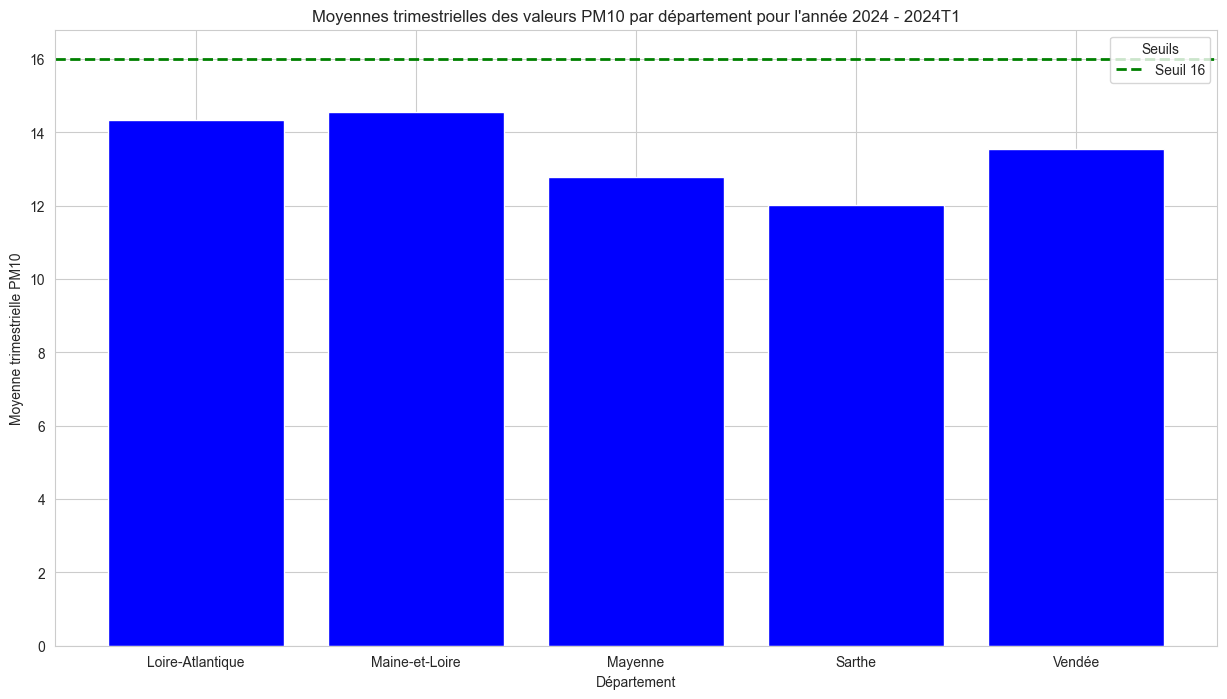

In [198]:
# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Supprimer le fuseau horaire avant la conversion en périodes trimestrielles
dfPM10['date_heure_tu'] = dfPM10['date_heure_tu'].dt.tz_localize(None)

# Ajouter les colonnes 'année' et 'trimestre'
dfPM10['année'] = dfPM10['date_heure_tu'].dt.year
dfPM10['trimestre'] = dfPM10['date_heure_tu'].dt.to_period('Q').astype(str).str.replace('Q', 'T')

# Calculer la moyenne trimestrielle de PM10 pour chaque département et chaque année
quarterly_means = dfPM10.groupby(['année', 'trimestre', 'departement_nom'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne trimestrielle dépasse le seuil
quarterly_means['depasse_seuil'] = (quarterly_means['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL)

# Créer la palette de couleurs
quarterly_means['color'] = ['red' if x else 'blue' for x in quarterly_means['depasse_seuil']]

# Créer un graphique en bâtons pour chaque année et trimestre
years = quarterly_means['année'].unique()

for year in years:
    annual_data = quarterly_means[quarterly_means['année'] == year]
    trimesters = annual_data['trimestre'].unique()

    for quarter in trimesters:
        plt.figure(figsize=(15, 8))
        quarterly_data = annual_data[annual_data['trimestre'] == quarter]
        colors = quarterly_data['color']
        plt.bar(quarterly_data['departement_nom'], quarterly_data['valeur'], color=colors)

        # Ajouter des lignes horizontales pour les seuils
        plt.axhline(y=OBJECTIF_QUALITE_PM10_MENSUEL, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_PM10_MENSUEL}')

        plt.xlabel('Département')
        plt.ylabel('Moyenne trimestrielle PM10')
        plt.title(f'Moyennes trimestrielles des valeurs PM10 par département pour l\'année {year} - {quarter}')
        plt.legend(title='Seuils')
        plt.xticks(rotation=0)  # Rotation pour mieux afficher les noms des départements
        plt.show()


#### Graphique pour voir trimestriel par département, par ville quand est-ce qu'on à dépassé le seuil de cible_objectif_qualité_PM10_mensuel


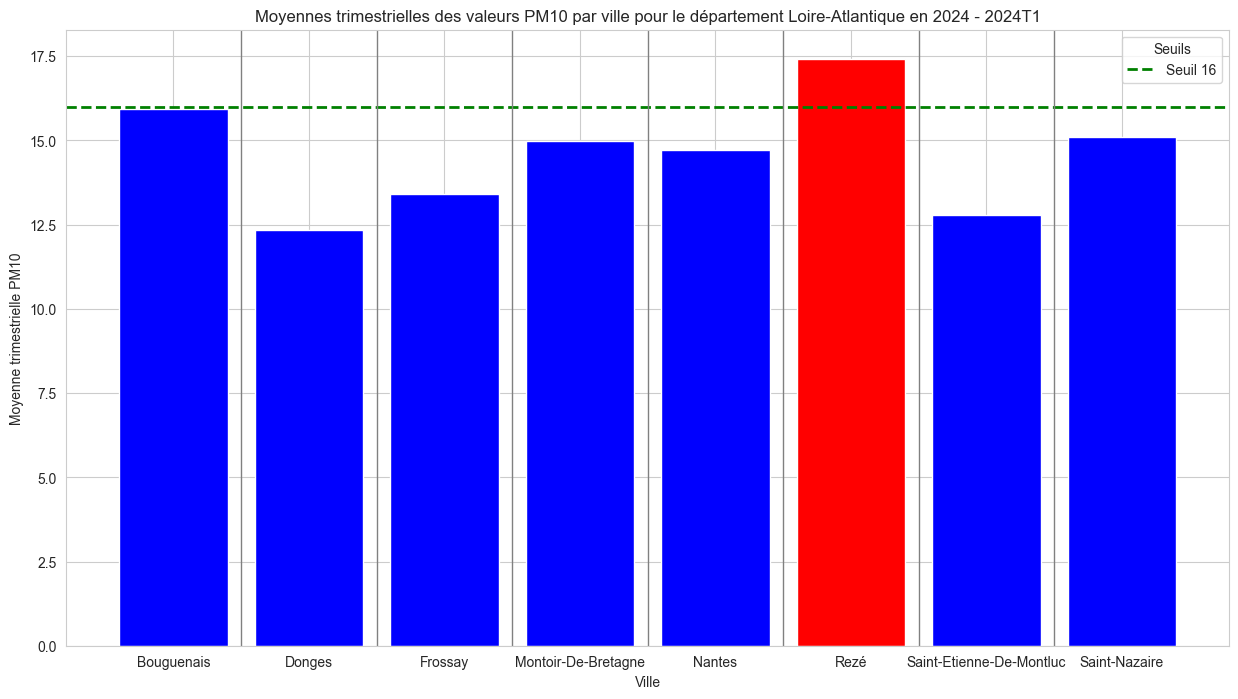

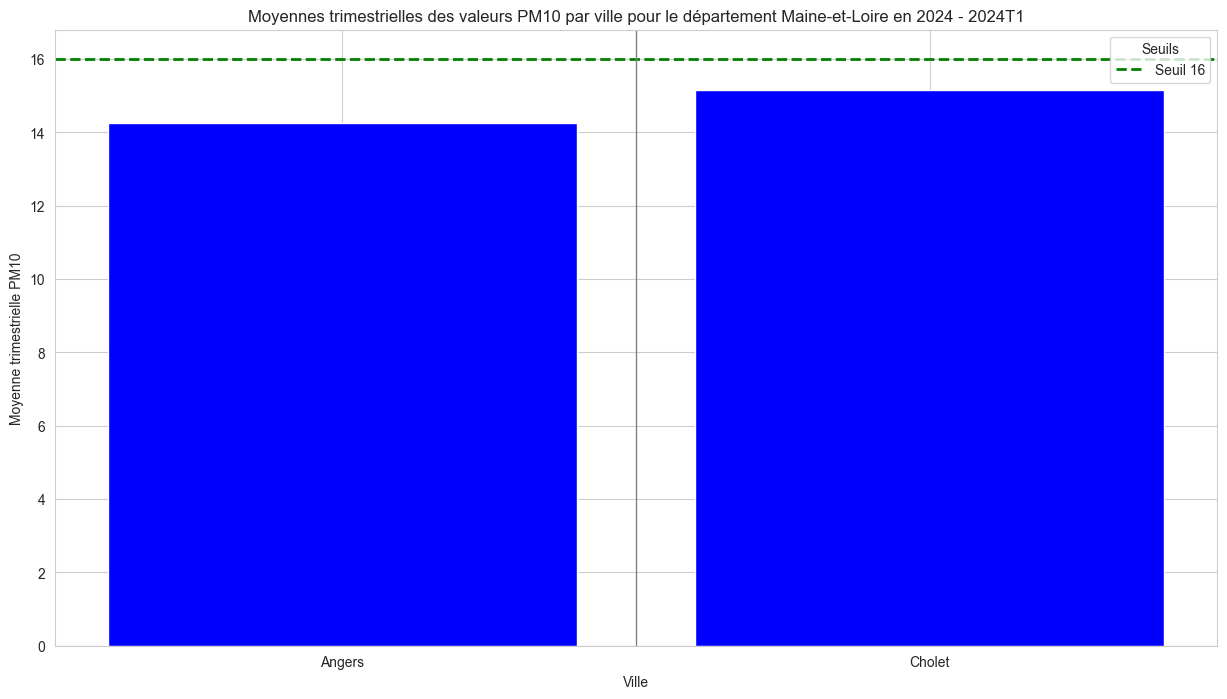

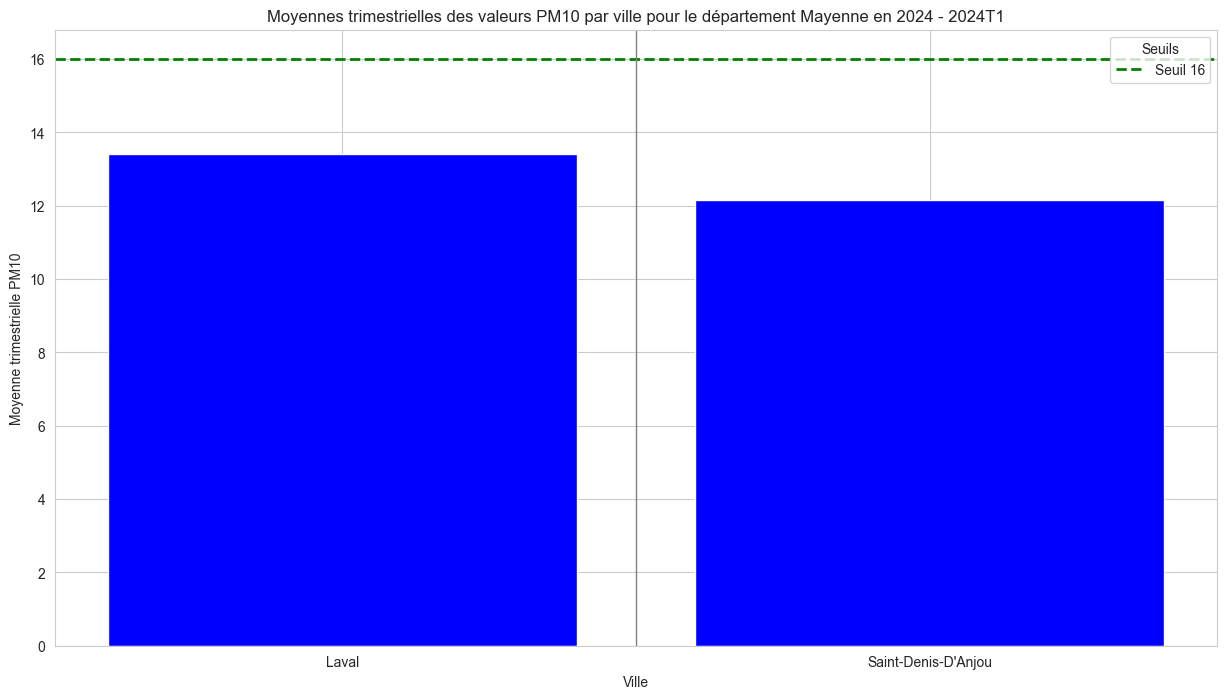

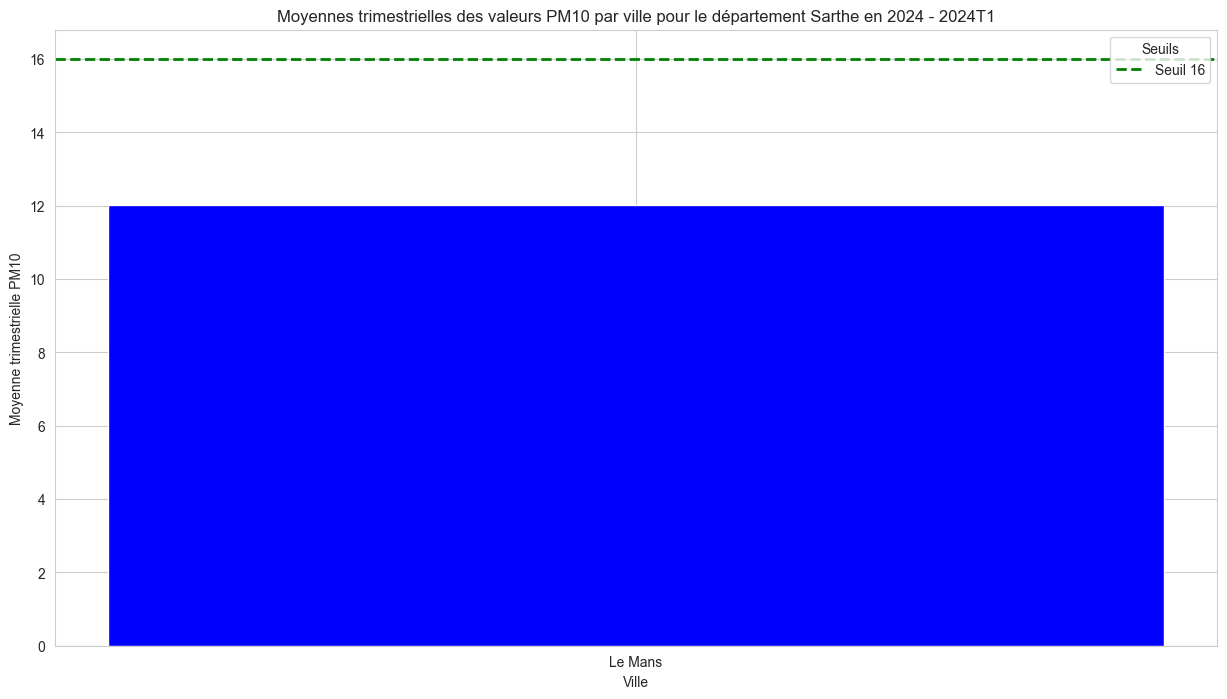

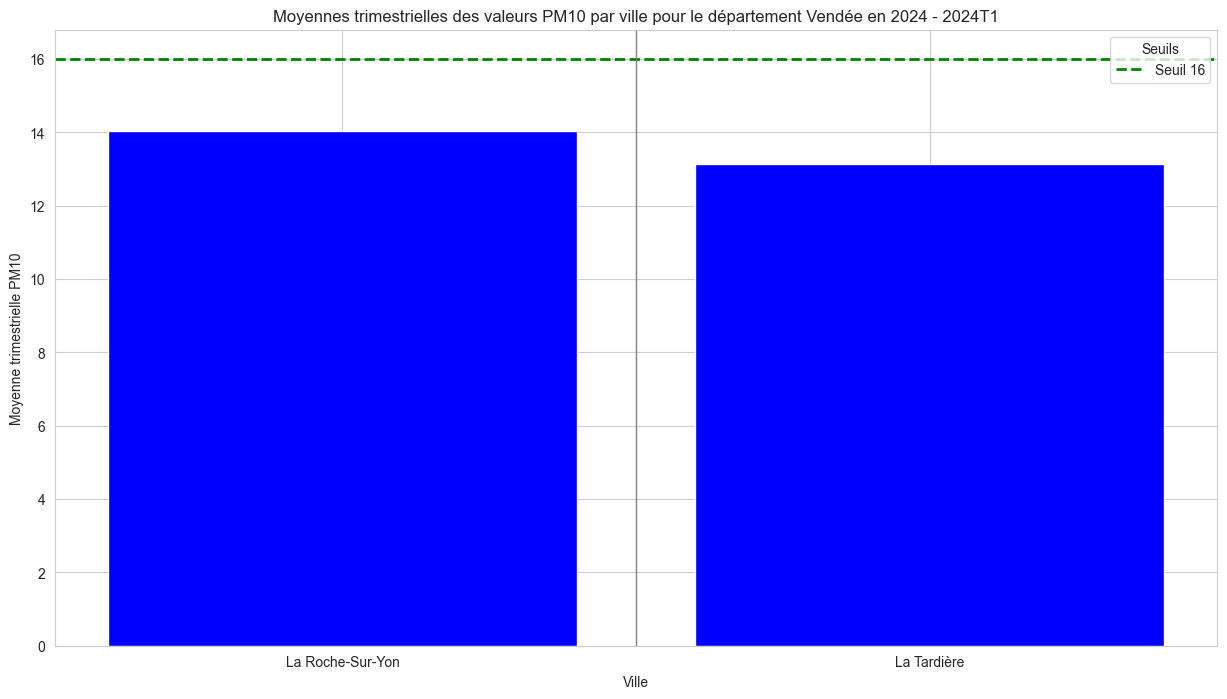

In [199]:
# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Supprimer le fuseau horaire avant la conversion en périodes trimestrielles
dfPM10['date_heure_tu'] = dfPM10['date_heure_tu'].dt.tz_localize(None)

# Ajouter les colonnes 'année' et 'trimestre'
dfPM10['année'] = dfPM10['date_heure_tu'].dt.year
dfPM10['trimestre'] = dfPM10['date_heure_tu'].dt.to_period('Q').astype(str).str.replace('Q', 'T')

# Calculer la moyenne trimestrielle de PM10 pour chaque département, chaque ville et chaque année
quarterly_means = dfPM10.groupby(['année', 'trimestre', 'departement_nom', 'nom_commune'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne trimestrielle dépasse les seuils
quarterly_means['depasse_seuil'] = (quarterly_means['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL)

# Créer la palette de couleurs
quarterly_means['color'] = ['red' if x else 'blue' for x in quarterly_means['depasse_seuil']]

# Créer un graphique en bâtons pour chaque année et chaque département
years = quarterly_means['année'].unique()
departments = quarterly_means['departement_nom'].unique()

for year in years:
    for department in departments:
        annual_dept_data = quarterly_means[(quarterly_means['année'] == year) & (quarterly_means['departement_nom'] == department)]
        
        if not annual_dept_data.empty:
            for quarter in annual_dept_data['trimestre'].unique():
                plt.figure(figsize=(15, 8))
                quarterly_data = annual_dept_data[annual_dept_data['trimestre'] == quarter]
                colors = quarterly_data['color']
                plt.bar(quarterly_data['nom_commune'], quarterly_data['valeur'], color=colors)

                # Ajouter des lignes horizontales pour les seuils
                plt.axhline(y=OBJECTIF_QUALITE_PM10_MENSUEL, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_PM10_MENSUEL}')

                # Ajouter des lignes verticales pour séparer les trimestres
                for i in range(1, len(quarterly_data['nom_commune'])):
                    plt.axvline(x=i - 0.5, color='grey', linestyle='-', linewidth=1)

                plt.xlabel('Ville')
                plt.ylabel('Moyenne trimestrielle PM10')
                plt.title(f'Moyennes trimestrielles des valeurs PM10 par ville pour le département {department} en {year} - {quarter}')
                plt.legend(title='Seuils')
                plt.xticks(rotation=0)  # Rotation pour mieux afficher les noms des villes
                plt.show()


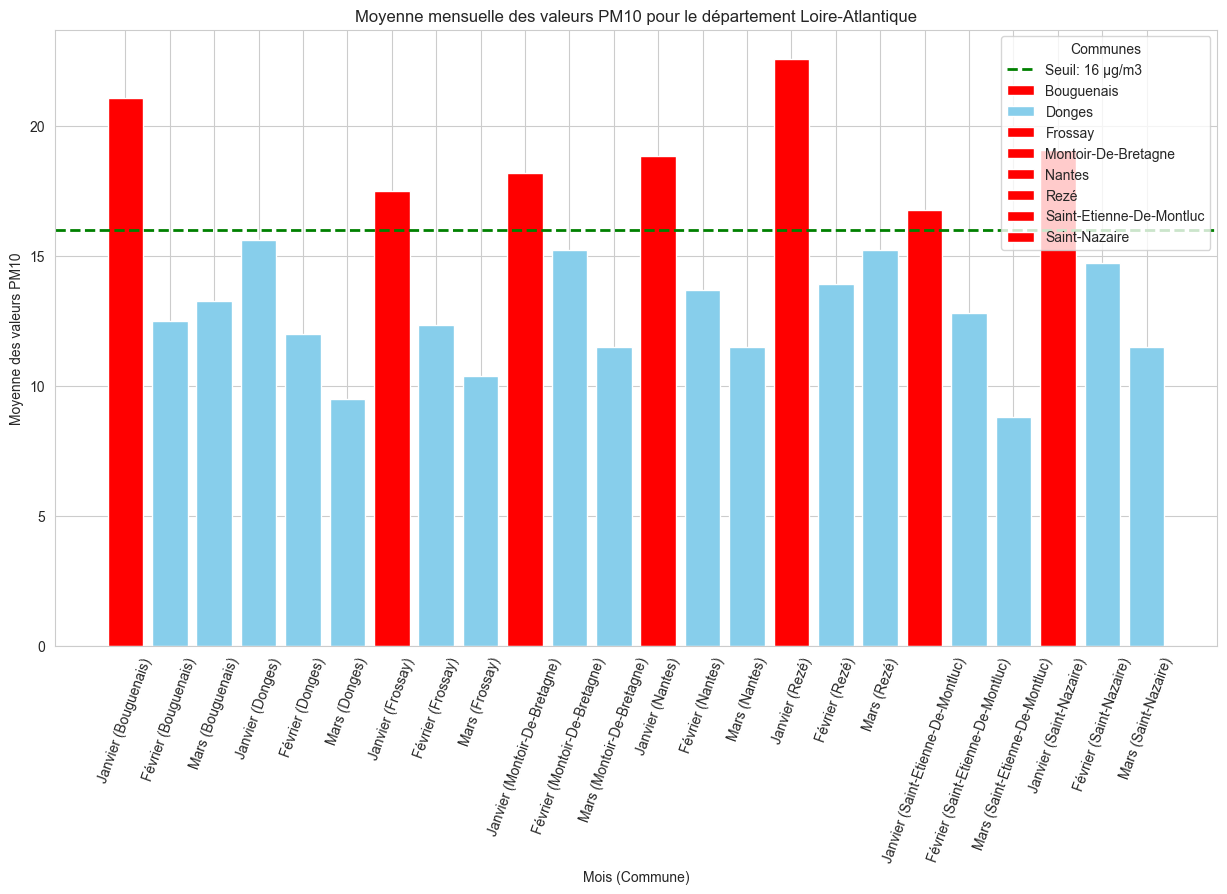

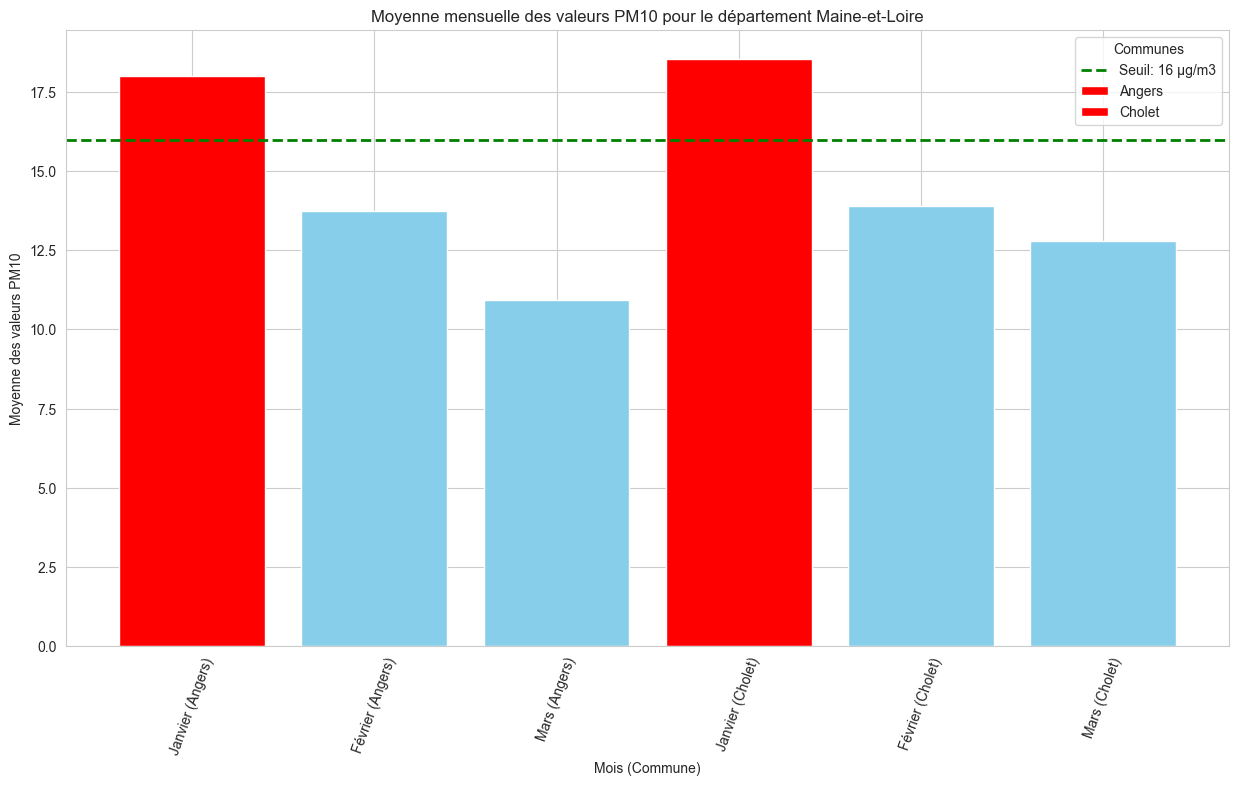

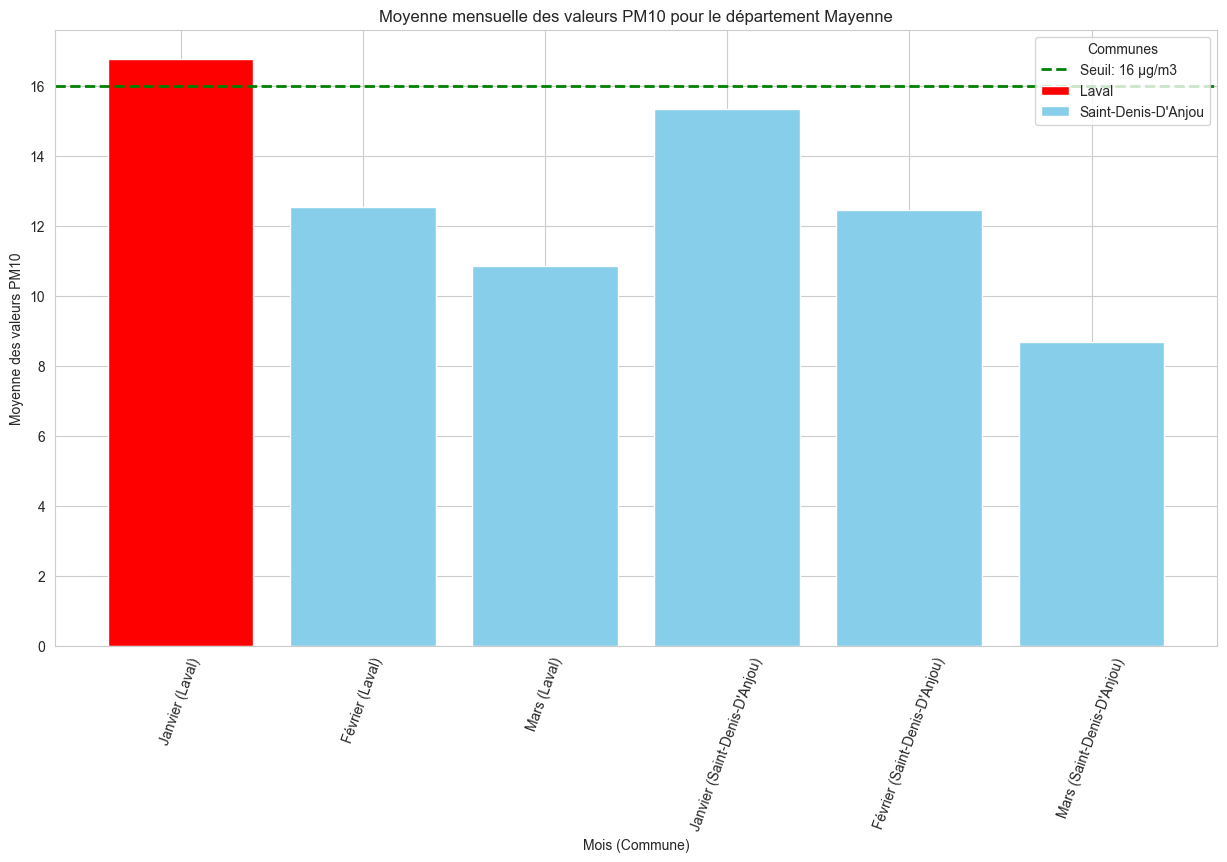

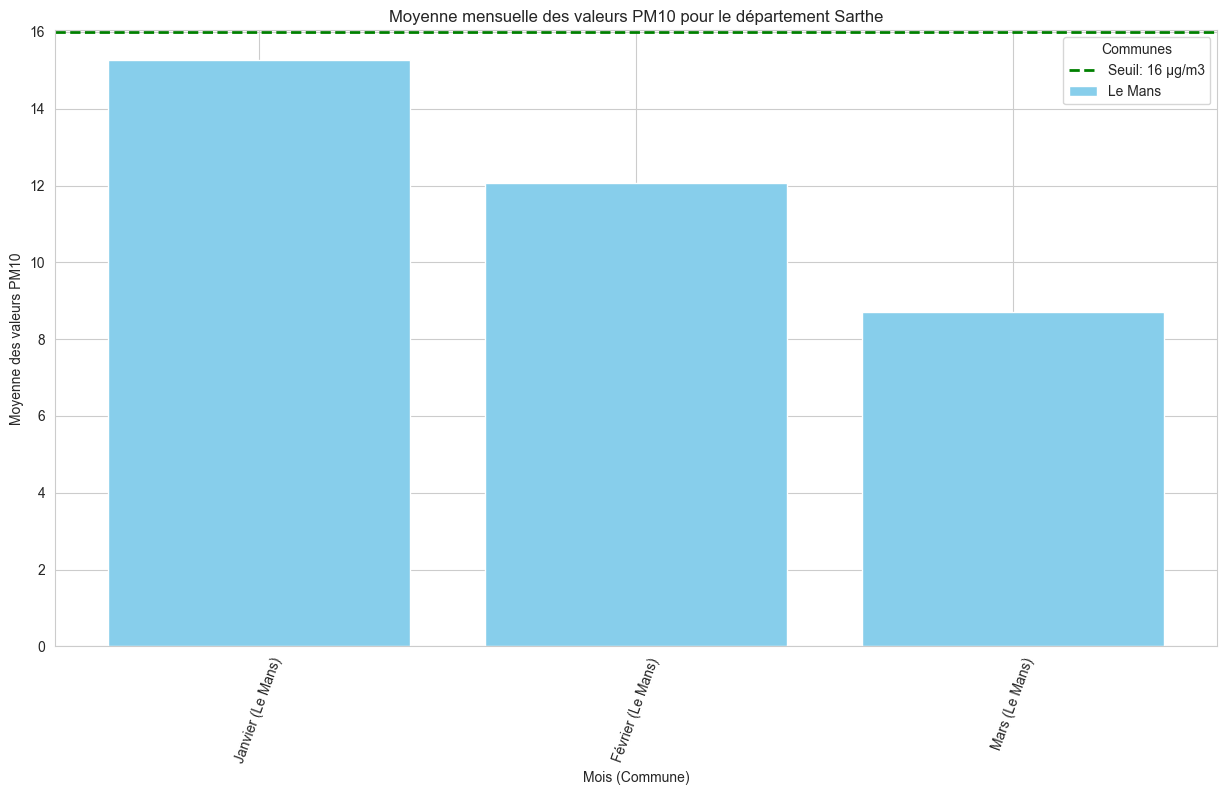

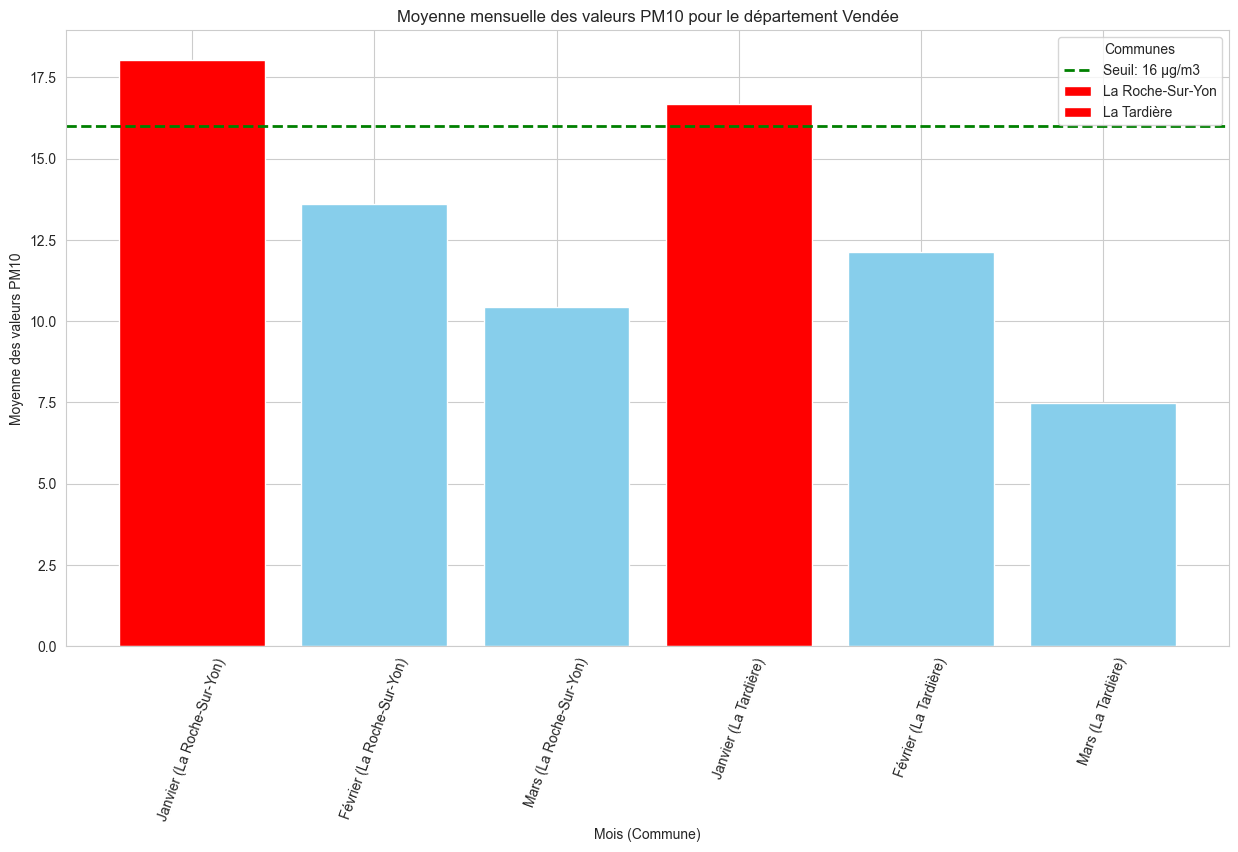

In [240]:
import locale

# Définir la locale en français
locale.setlocale(locale.LC_TIME, 'fr_FR.UTF-8')

# Ajouter la colonne 'mois' pour grouper par mois
dfPM10['mois'] = dfPM10['date_heure_tu'].dt.month

# Calculer la moyenne mensuelle des valeurs de PM10 pour chaque département et chaque commune
monthly_means = dfPM10.groupby(['departement_nom', 'nom_commune', 'mois'])['valeur'].mean().reset_index()

# Convertir les numéros des mois en noms de mois
monthly_means['mois_lettres'] = monthly_means['mois'].apply(lambda x: calendar.month_name[x].capitalize())

# Ajouter une colonne indiquant si la moyenne mensuelle dépasse le seuil
monthly_means['depasse_seuil'] = monthly_means['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL

# Obtenir la liste des départements uniques
departments = monthly_means['departement_nom'].unique()

# Créer un graphique en barres pour chaque département regroupant les communes
for department in departments:
    dept_data = monthly_means[monthly_means['departement_nom'] == department]
    
    plt.figure(figsize=(15, 8))
    
    # Grouper les communes dans le département
    communes = dept_data['nom_commune'].unique()
    for commune in communes:
        commune_data = dept_data[dept_data['nom_commune'] == commune]
        colors = commune_data['depasse_seuil'].map({True: 'red', False: 'skyblue'})
        bars = plt.bar(commune_data['mois_lettres'] + " (" + commune + ")", commune_data['valeur'], color=colors, label=commune)
    
    # Ajouter une ligne horizontale pour le seuil OBJECTIF_QUALITE_PM10_MENSUEL
    plt.axhline(y=OBJECTIF_QUALITE_PM10_MENSUEL, color='green', linestyle='--', linewidth=2, label=f'Seuil: {OBJECTIF_QUALITE_PM10_MENSUEL} µg/m3')
    
    plt.xlabel('Mois (Commune)')
    plt.ylabel('Moyenne des valeurs PM10')
    plt.title(f'Moyenne mensuelle des valeurs PM10 pour le département {department}')
    plt.legend(title='Communes')
    plt.xticks(rotation=70)  # Rotation pour mieux afficher les noms des communes et des mois
    plt.show()


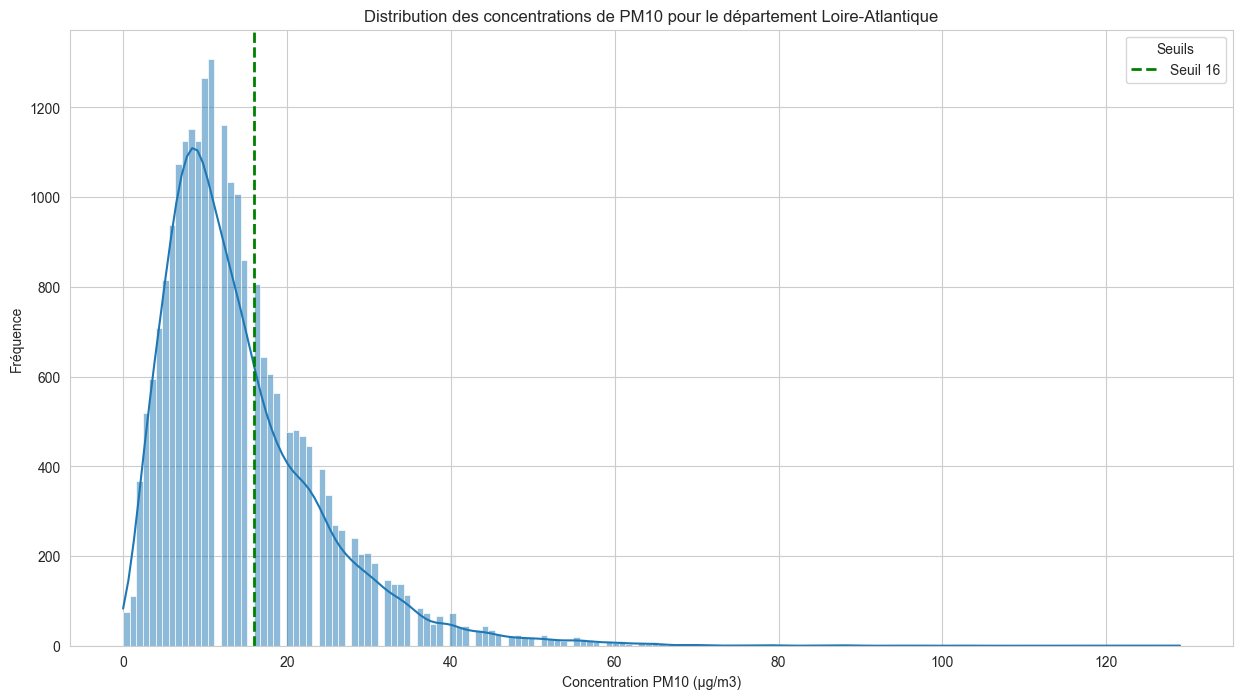

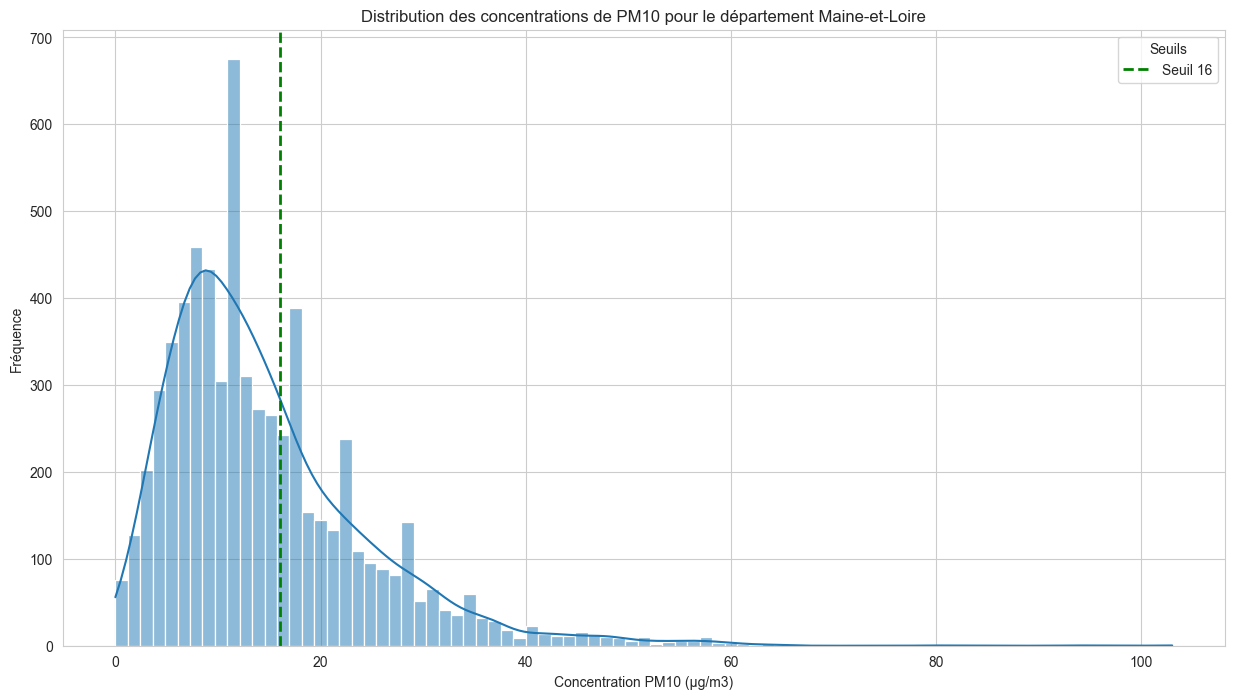

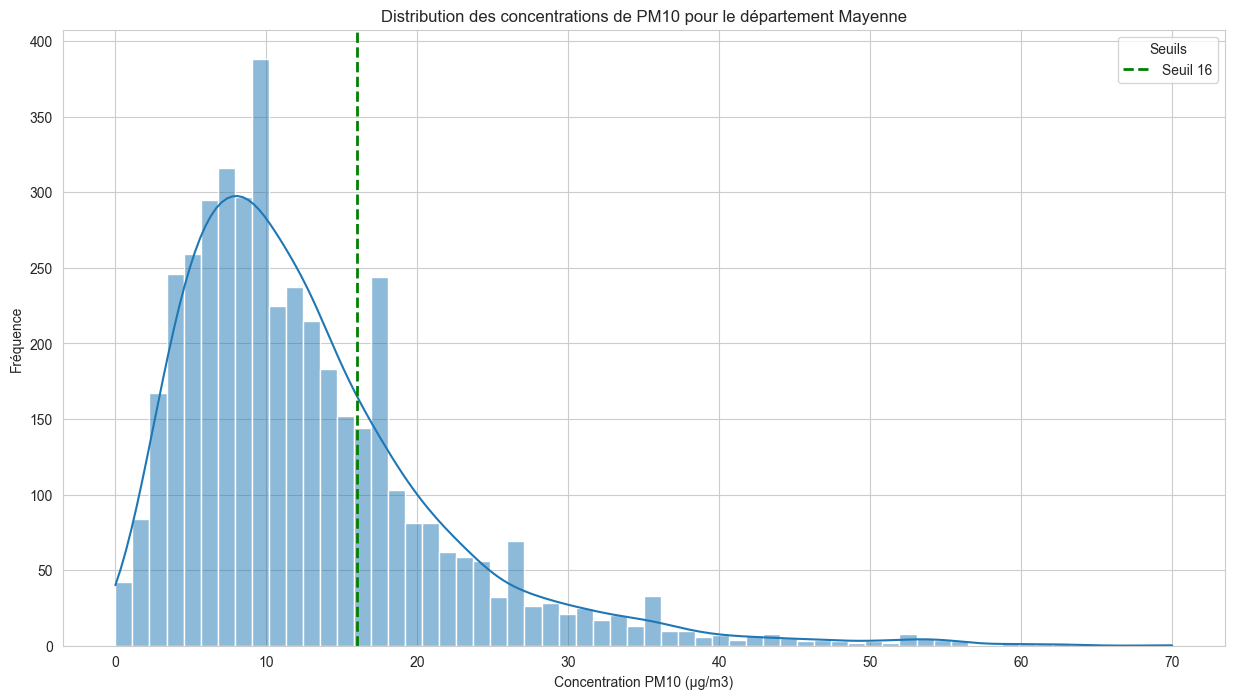

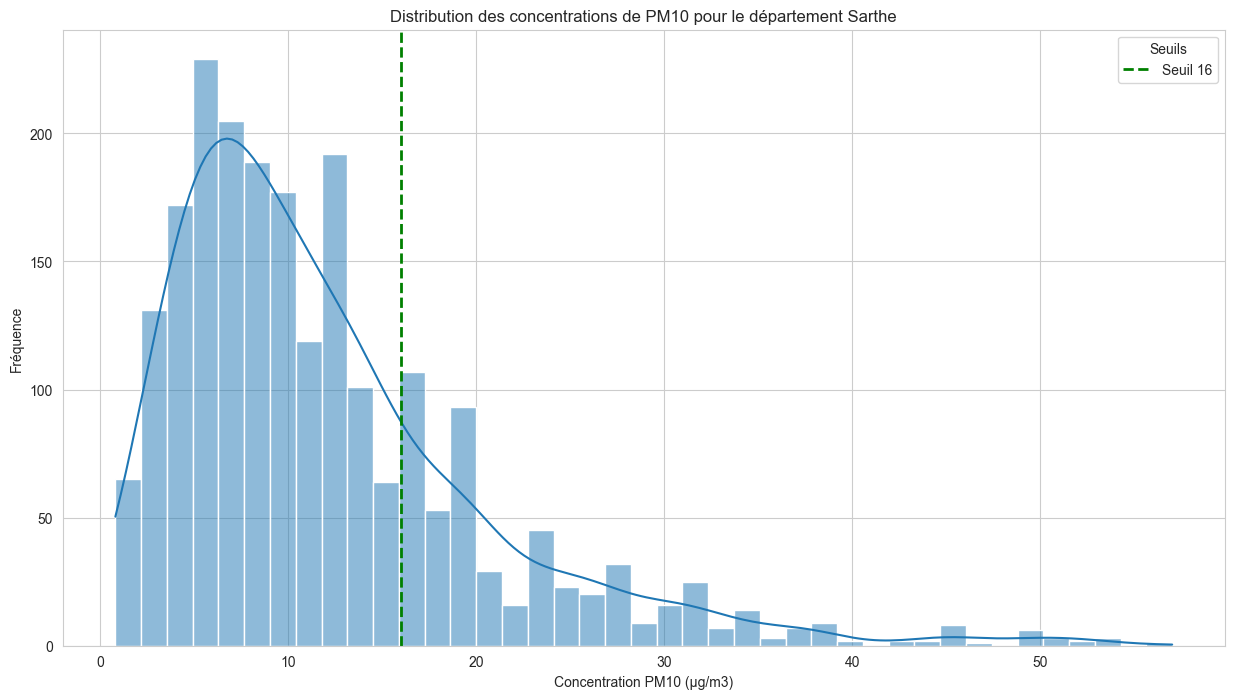

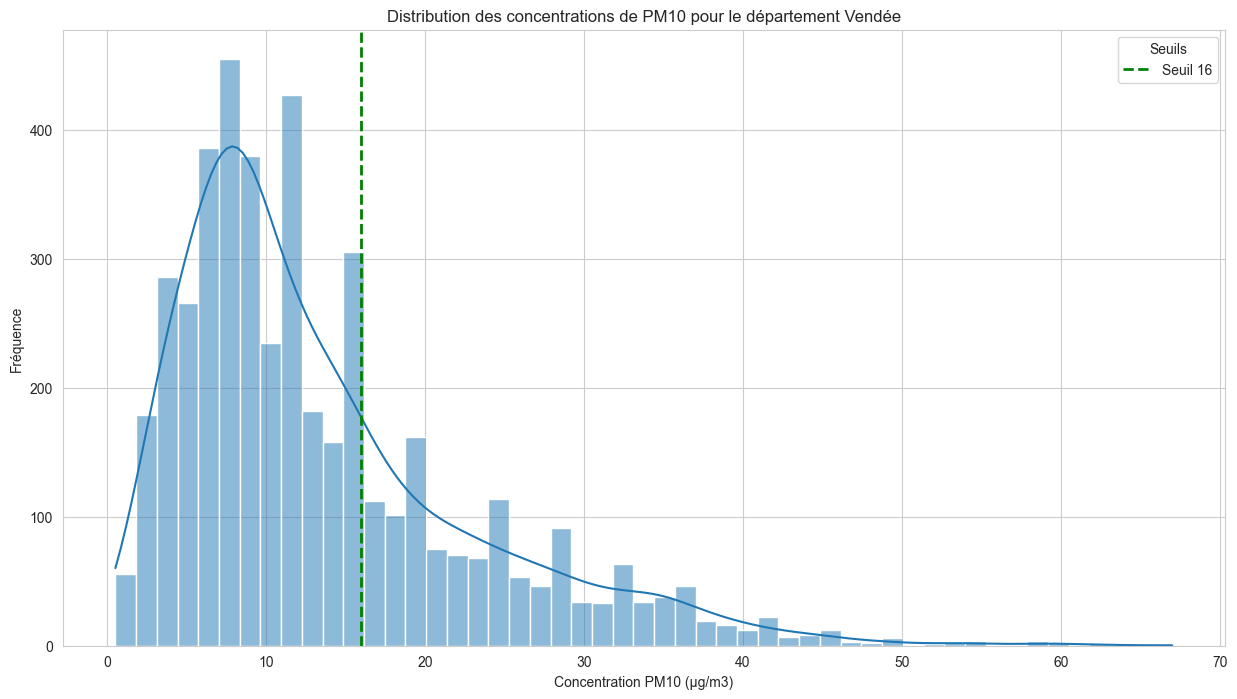

In [200]:
# Créer un histogramme pour chaque département
for department in departments:
    plt.figure(figsize=(15, 8))
    dept_data = dfPM10[dfPM10['departement_nom'] == department]
    
    sns.histplot(dept_data['valeur'], kde=True)
    
    plt.axvline(x=OBJECTIF_QUALITE_PM10_MENSUEL, color='green', linestyle='--', linewidth=2, label=f'Seuil {OBJECTIF_QUALITE_PM10_MENSUEL}')
    
    plt.xlabel('Concentration PM10 (µg/m3)')
    plt.ylabel('Fréquence')
    plt.title(f'Distribution des concentrations de PM10 pour le département {department}')
    plt.legend(title='Seuils')
    plt.show()


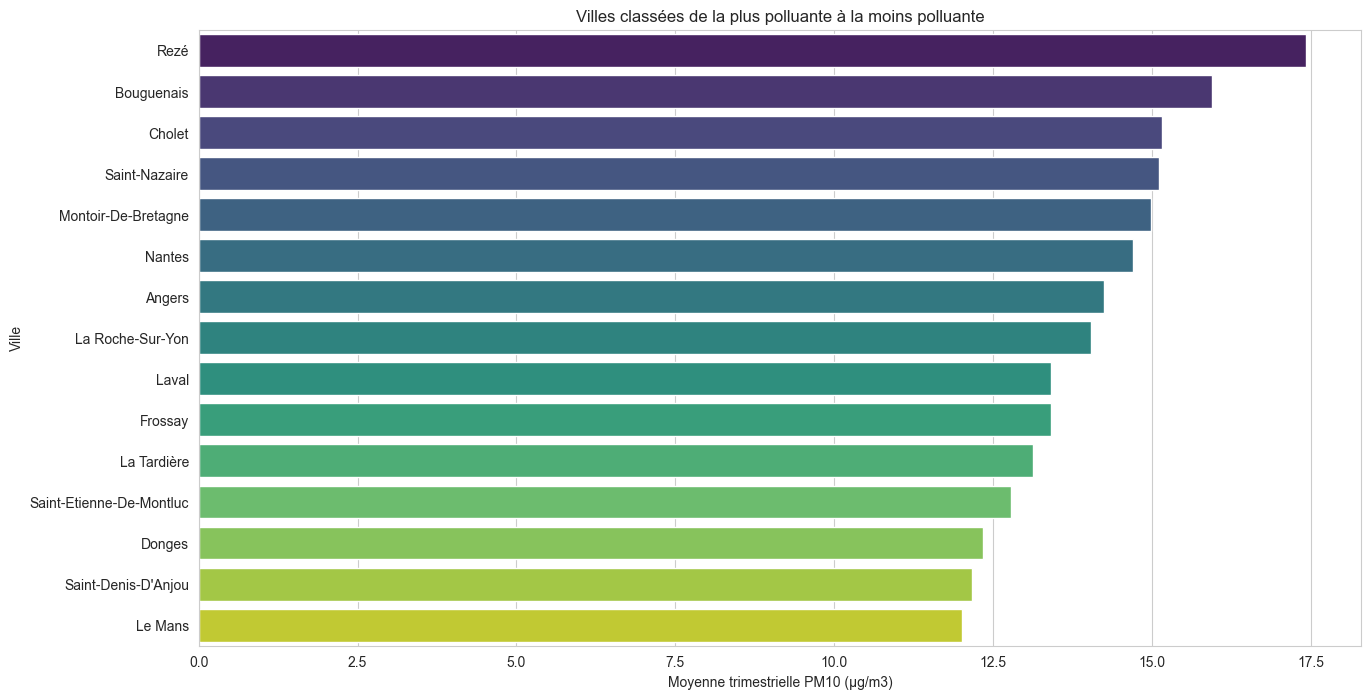

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculer la moyenne annuelle de PM10 pour chaque ville
city_means = dfPM10.groupby('nom_commune')['valeur'].mean().reset_index()

# Trier les villes de la plus polluante à la moins polluante
city_means = city_means.sort_values(by='valeur', ascending=False)

# Créer un graphique en bâtons pour les villes
plt.figure(figsize=(15, 8))
sns.barplot(data=city_means, x='valeur', y='nom_commune', hue='nom_commune', dodge=False, palette='viridis', legend=False)

plt.xlabel('Moyenne trimestrielle PM10 (µg/m3)')
plt.ylabel('Ville')
plt.title('Villes classées de la plus polluante à la moins polluante')
plt.show()


### les valeurs pour le premier trimestre 2024 dépassent le seuil d'information et de recommandation (SEUIL_INFO_RECO),

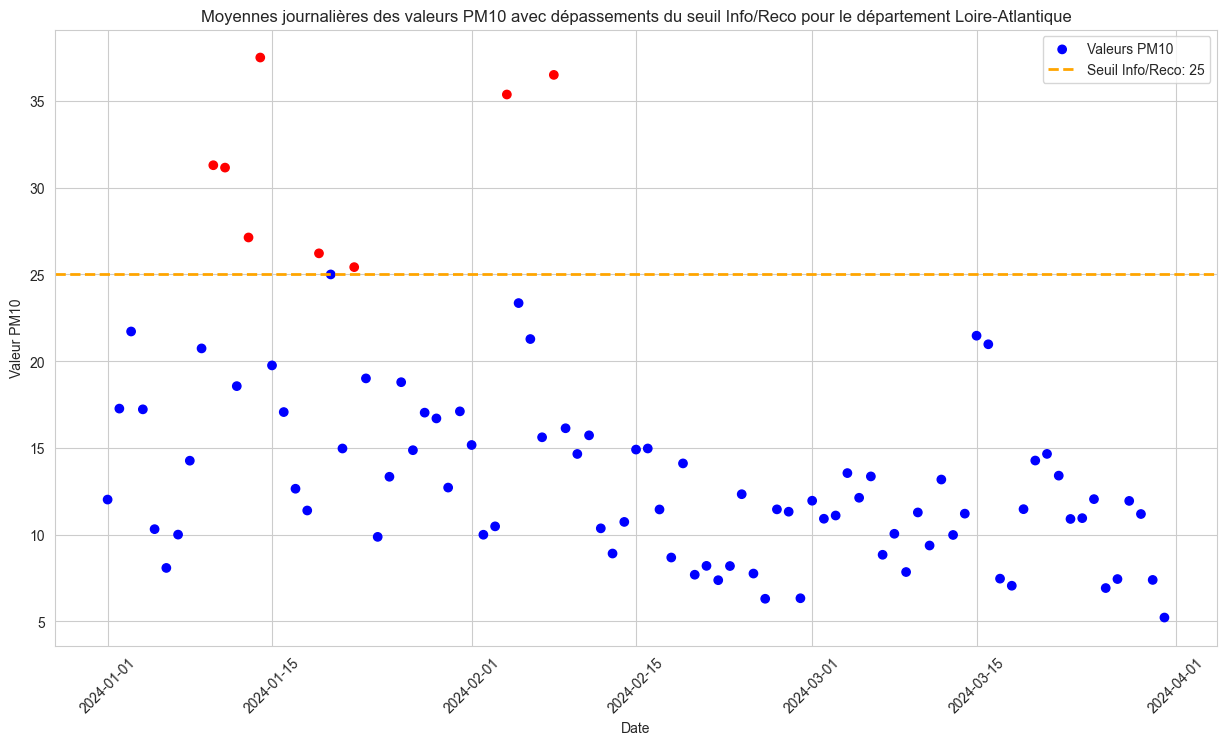

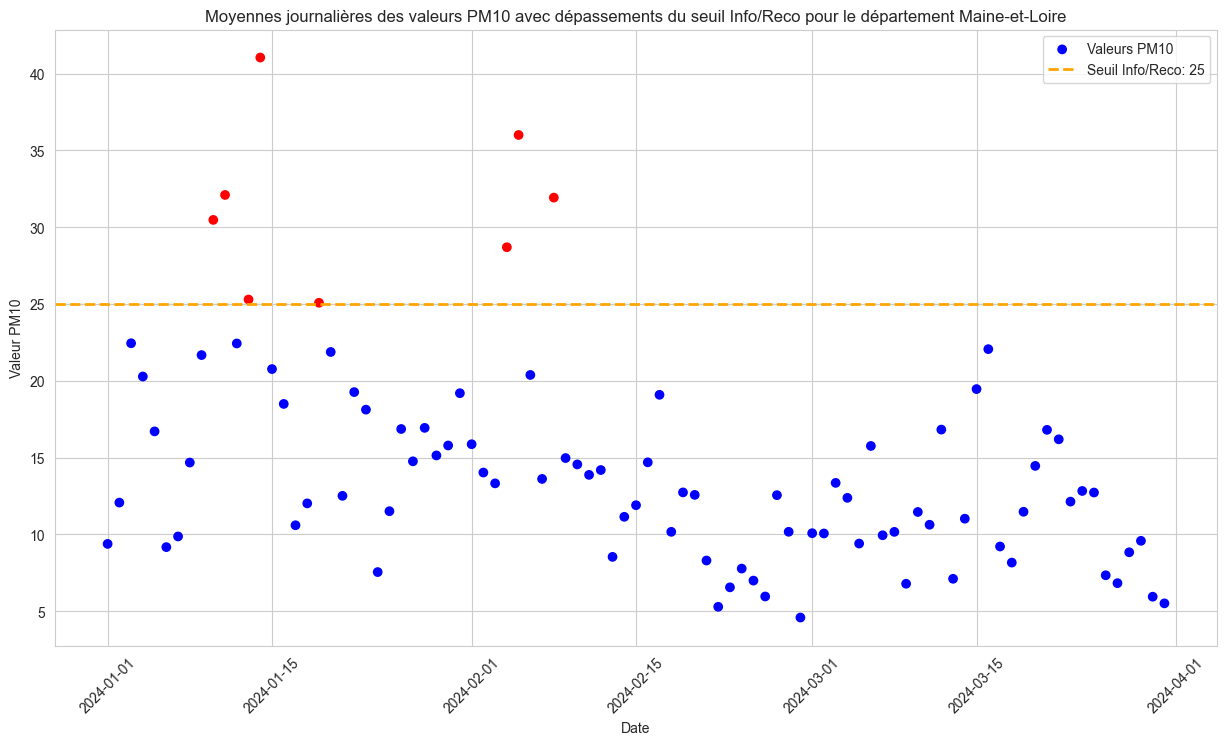

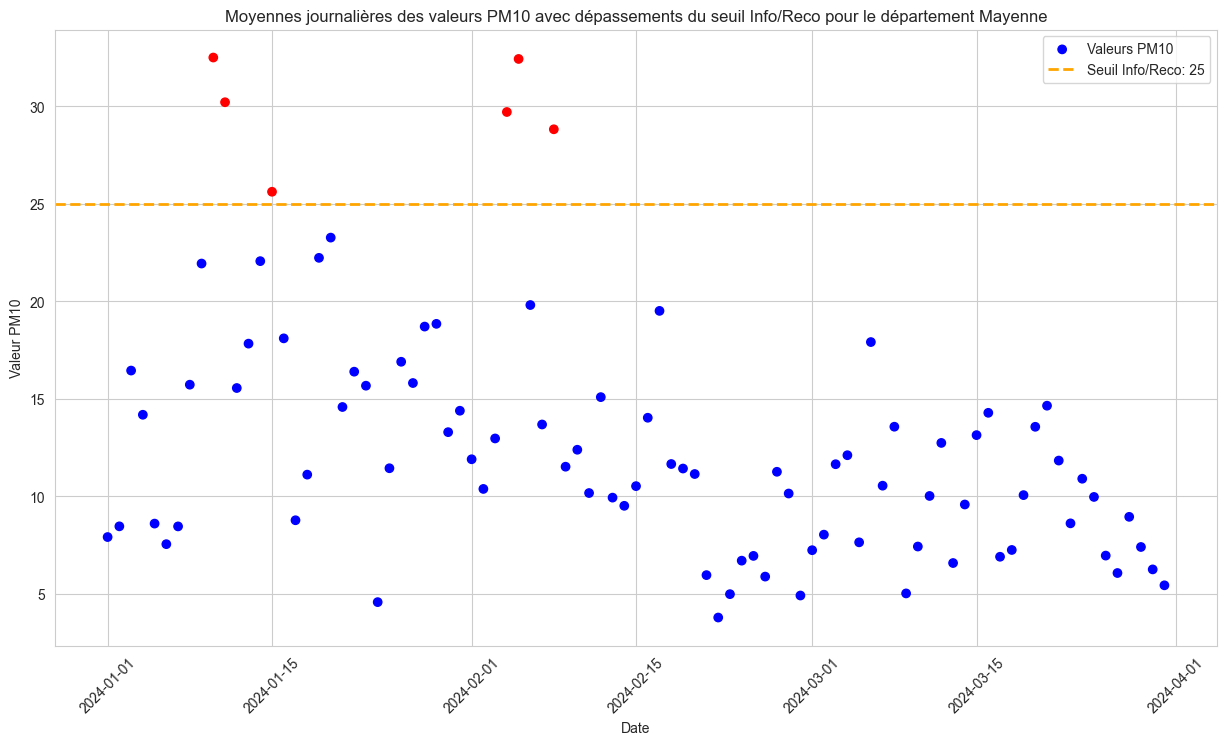

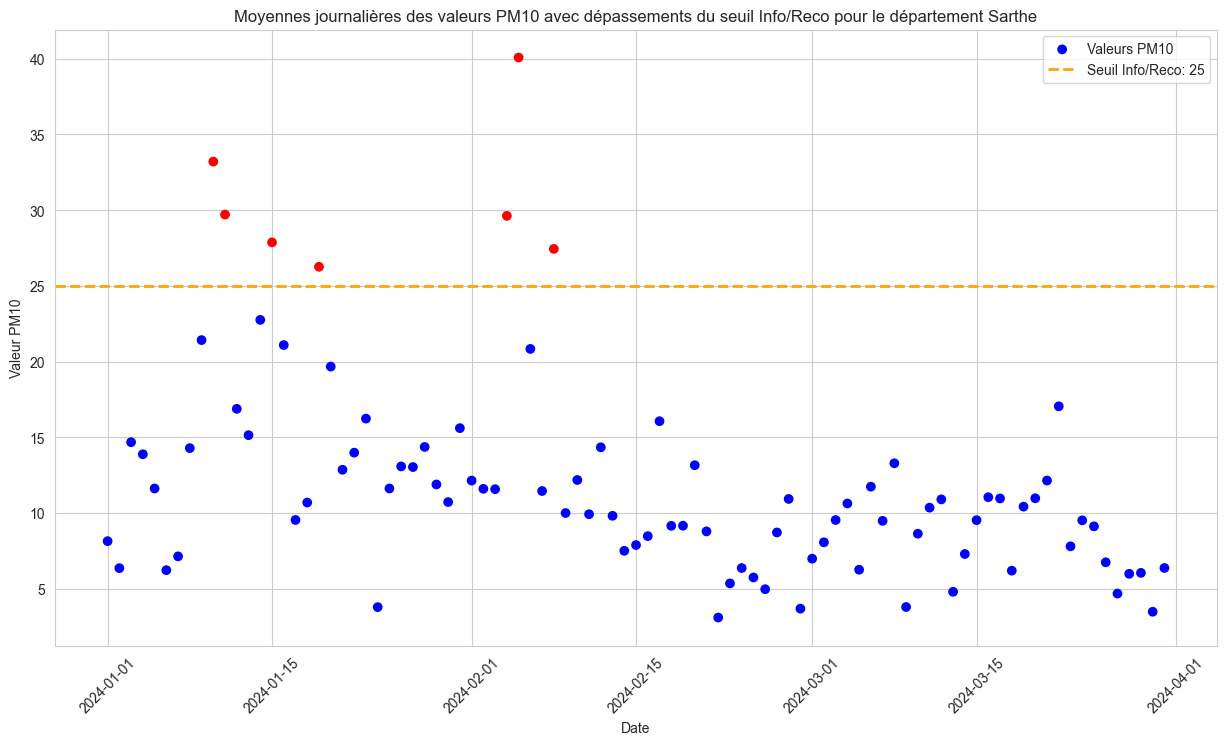

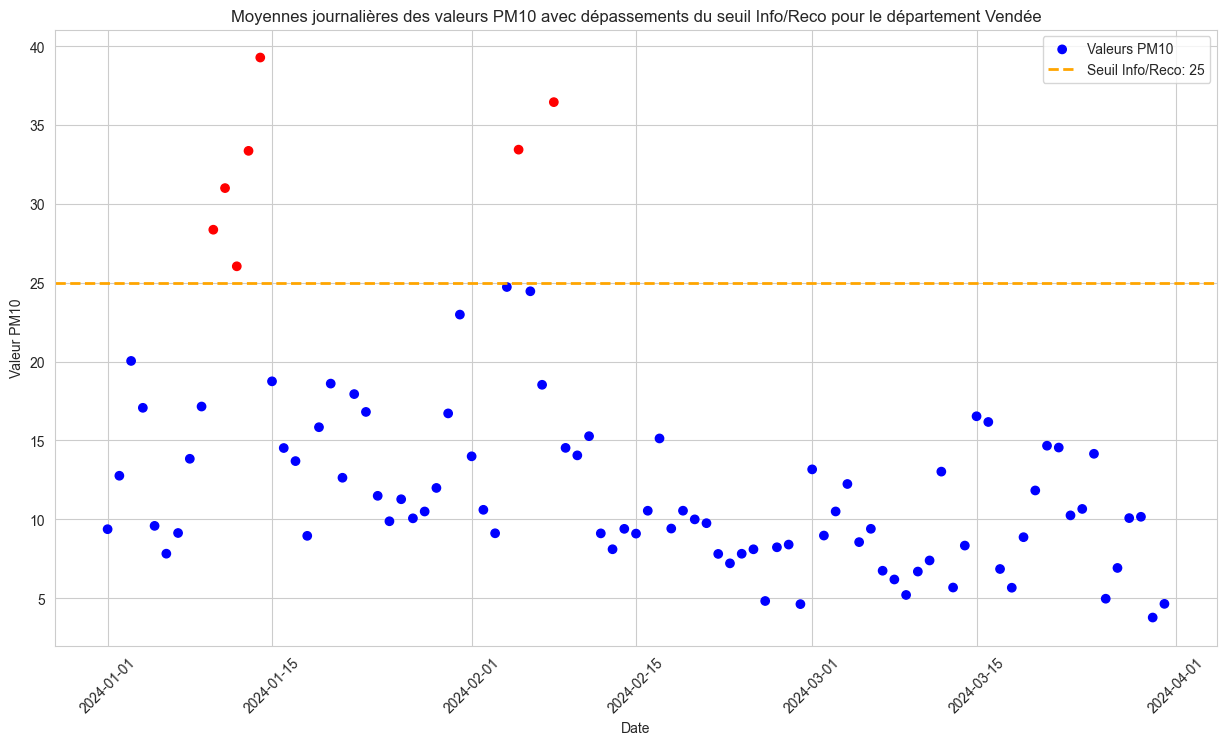

In [242]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Ajouter la colonne 'jour' pour grouper par jour
dfPM10['jour'] = dfPM10['date_heure_tu'].dt.date

# Calculer la moyenne journalière des valeurs de PM10 par département
daily_means = dfPM10.groupby(['jour', 'departement_nom'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne journalière dépasse le seuil d'information et de recommandation
daily_means['depasse_seuil_info_reco'] = daily_means['valeur'] > SEUIL_INFO_RECO

# Obtenir la liste des départements uniques
departments = daily_means['departement_nom'].unique()

# Créer un graphique pour chaque département
for department in departments:
    dept_data = daily_means[daily_means['departement_nom'] == department]
    
    plt.figure(figsize=(15, 8))
    
    # Tracer les valeurs avec une couleur différente pour celles qui dépassent le seuil
    colors = ['red' if x else 'blue' for x in dept_data['depasse_seuil_info_reco']]
    plt.scatter(dept_data['jour'], dept_data['valeur'], c=colors, label='Valeurs PM10')
    
    # Ajouter des lignes horizontales pour les seuils
    plt.axhline(y=SEUIL_INFO_RECO, color='orange', linestyle='--', linewidth=2, label=f'Seuil Info/Reco: {SEUIL_INFO_RECO}')
    
    plt.xlabel('Date')
    plt.ylabel('Valeur PM10')
    plt.title(f'Moyennes journalières des valeurs PM10 avec dépassements du seuil Info/Reco pour le département {department}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


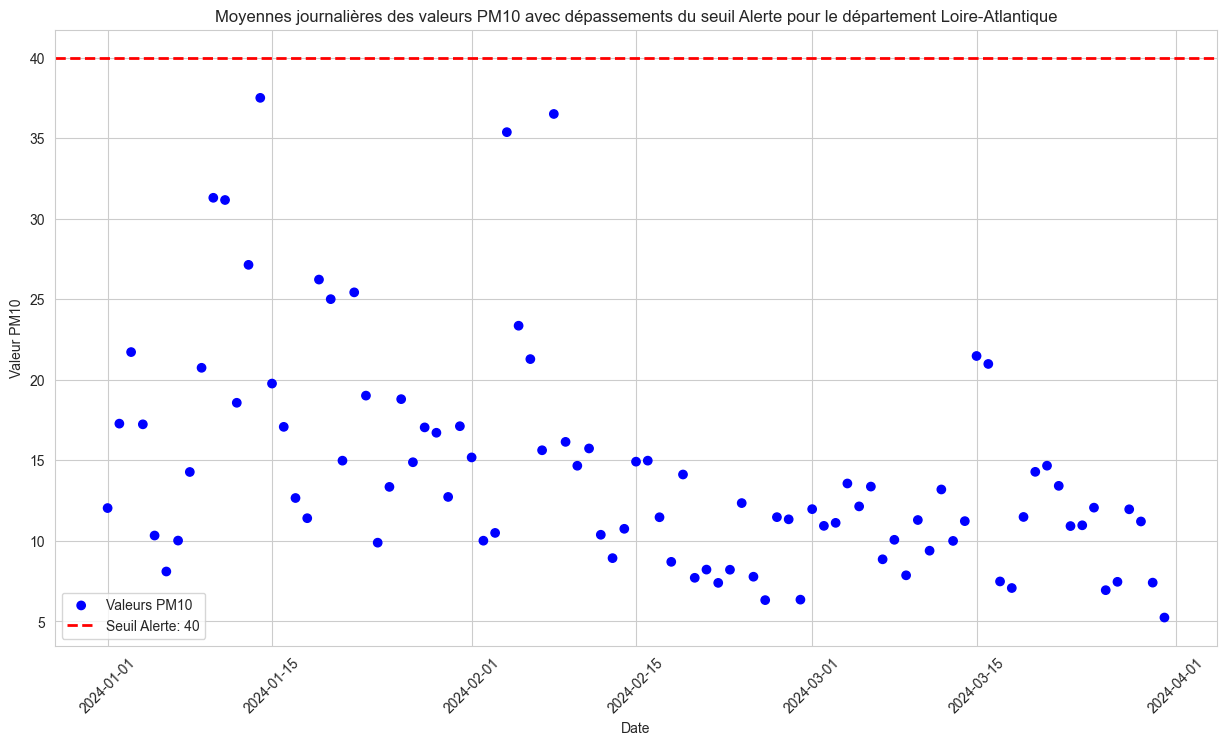

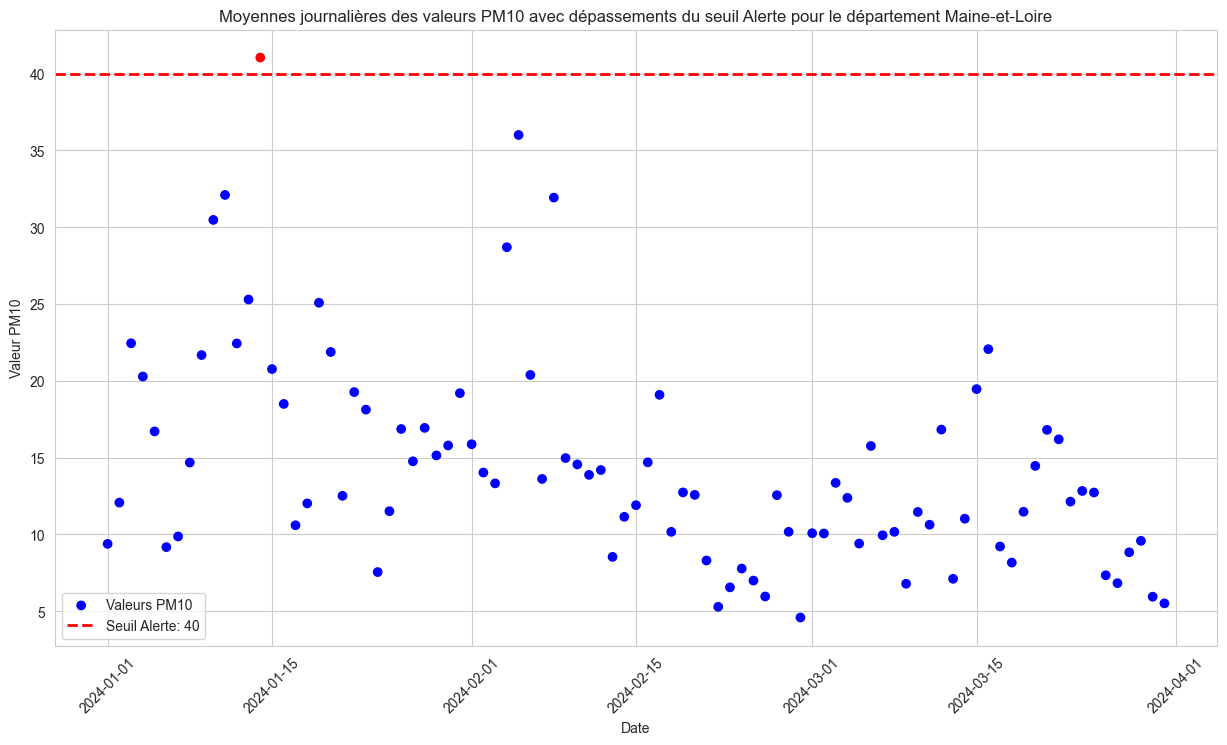

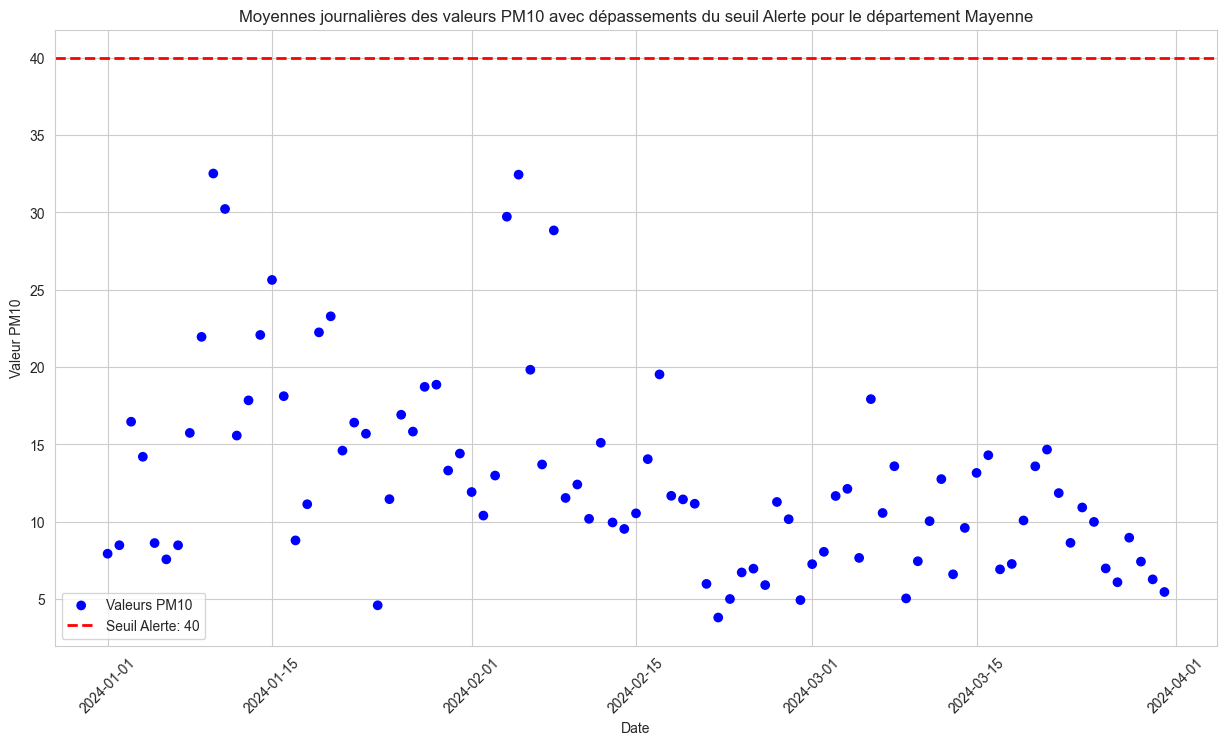

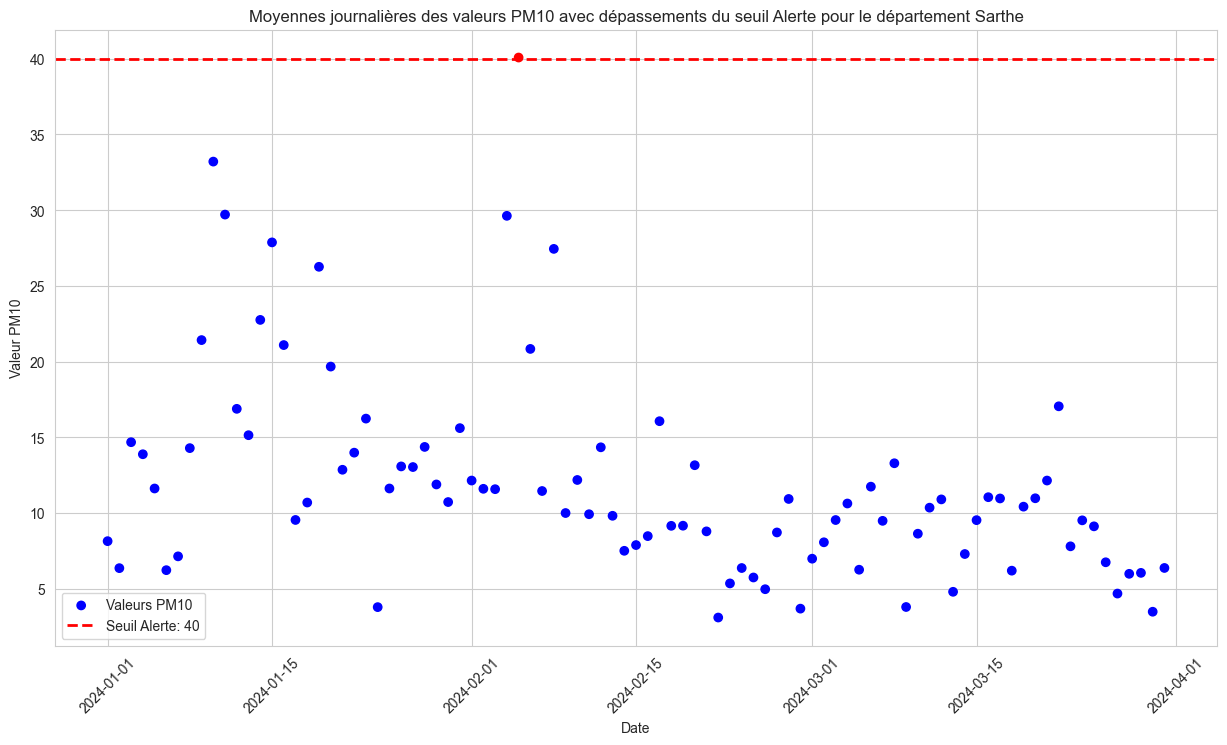

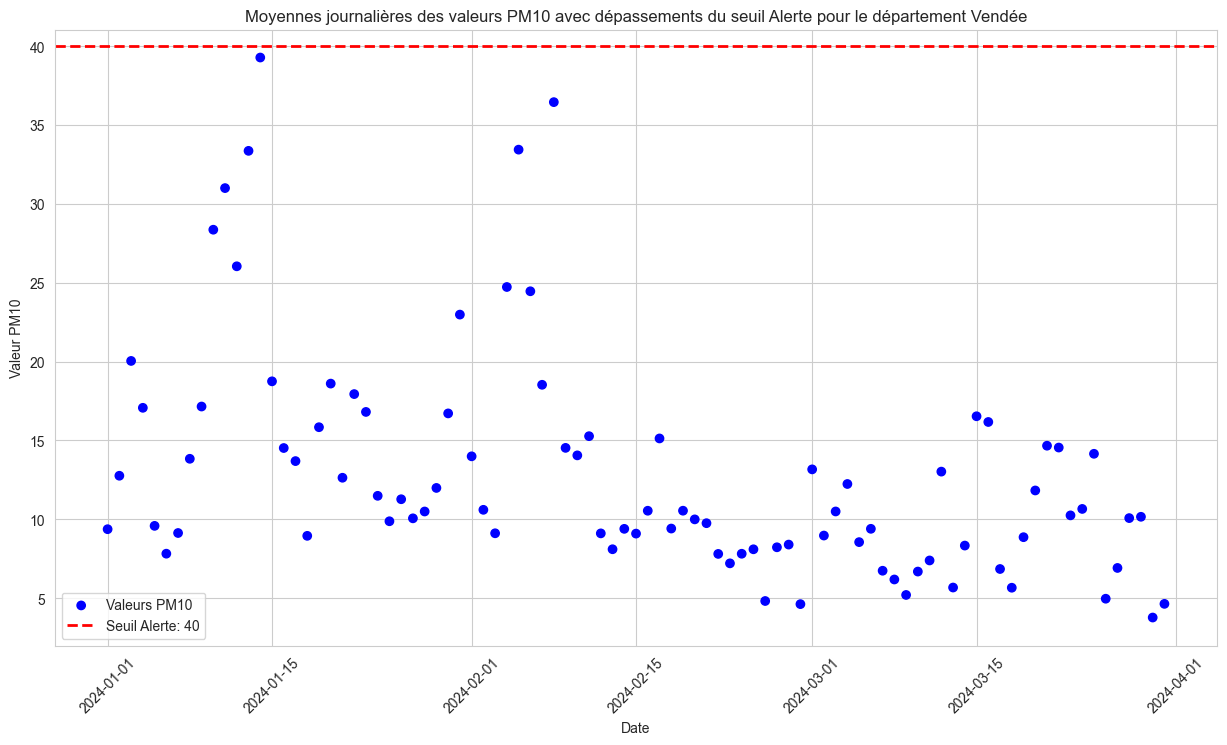

In [243]:
import pandas as pd
import matplotlib.pyplot as plt

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Ajouter la colonne 'jour' pour grouper par jour
dfPM10['jour'] = dfPM10['date_heure_tu'].dt.date

# Calculer la moyenne journalière des valeurs de PM10 par département
daily_means = dfPM10.groupby(['jour', 'departement_nom'])['valeur'].mean().reset_index()

# Ajouter une colonne indiquant si la moyenne journalière dépasse le seuil d'alerte
daily_means['depasse_seuil_alerte'] = daily_means['valeur'] > SEUIL_ALERTE

# Obtenir la liste des départements uniques
departments = daily_means['departement_nom'].unique()

# Créer un graphique pour chaque département
for department in departments:
    dept_data = daily_means[daily_means['departement_nom'] == department]
    
    plt.figure(figsize=(15, 8))
    
    # Tracer les valeurs avec une couleur différente pour celles qui dépassent le seuil
    colors = ['red' if x else 'blue' for x in dept_data['depasse_seuil_alerte']]
    plt.scatter(dept_data['jour'], dept_data['valeur'], c=colors, label='Valeurs PM10')
    
    # Ajouter des lignes horizontales pour les seuils
    plt.axhline(y=SEUIL_ALERTE, color='red', linestyle='--', linewidth=2, label=f'Seuil Alerte: {SEUIL_ALERTE}')
    
    plt.xlabel('Date')
    plt.ylabel('Valeur PM10')
    plt.title(f'Moyennes journalières des valeurs PM10 avec dépassements du seuil Alerte pour le département {department}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()


## Fusion des données avec le jeu de données dfPopulation

In [204]:
# Importer la fonction depuis le fichier Python
from population import fetch_and_process_population_data

# Utilisation de la fonction importée
base_url = "https://data.paysdelaloire.fr/api/explore/v2.1/catalog/datasets/12002701600563_population_pays_de_la_loire_2019_communes_epci/records"
dfPopulation = fetch_and_process_population_data(base_url)

# Afficher les premières lignes du DataFrame dfPopulation pour vérifier les modifications
print(dfPopulation.head())

# Afficher les types de colonnes pour vérifier les conversions
print(dfPopulation.dtypes)

Total records retrieved: 1238
   code_region  nom_de_la_region  code_departement  code_arrondissement  \
0           52  Pays de la Loire                44                    3   
1           52  Pays de la Loire                44                    2   
2           52  Pays de la Loire                44                    3   
3           52  Pays de la Loire                44                    2   
4           52  Pays de la Loire                44                    3   

   code_canton  code_commune nom_de_la_commune  population_municipale  \
0            9         44006           Assérac                 1790.0   
1           21         44018            Bouaye                 7844.0   
2           89         44005   Chaumes-en-Retz                 6759.0   
3           24         44047           Couëron                21372.0   
4            2         44049        Le Croisic                 4093.0   

   population_comptee_a_part  population_totale  \
0                       32.0 

In [205]:
# Fusionner les deux DataFrames en utilisant les colonnes 'nom_commune' et 'nom_de_la_commune' avec une jointure externe gauche
if 'nom_commune' in dfPM10.columns and 'nom_de_la_commune' in dfPopulation.columns:
    dfMerged = pd.merge(dfPM10, dfPopulation, left_on='nom_commune', right_on='nom_de_la_commune', how='left', suffixes=('_pm10', '_pop'))
    
    # Sauvegarder le DataFrame fusionné pour utilisation ultérieure
    dfMerged.to_pickle('MergedData.pkl')

    # Afficher les premières lignes du DataFrame fusionné
    print("dfMerged:")
    print(dfMerged.head())
else:
    print("Les colonnes de fusion 'nom_commune' et 'nom_de_la_commune' ne sont pas présentes dans les DataFrames. Vérifiez les colonnes disponibles.")

# Charger le DataFrame depuis le fichier sauvegardé
dfPM10 = pd.read_pickle('MergedData.pkl')

# Afficher les types de chaque colonne
print(dfPM10.dtypes)

dfMerged:
                                  id  code_polluant code_point_de_prelevement  \
0  2024-03-31 23:00:00FR23003_PM10_1             24              FR23003_PM10   
1  2024-03-31 23:00:00FR23068_PM10_4             24              FR23068_PM10   
2  2024-03-31 23:00:00FR23070_PM10_3             24              FR23070_PM10   
3  2024-03-31 23:00:00FR23107_PM10_4             24              FR23107_PM10   
4  2024-03-31 23:00:00FR23110_PM10_3             24              FR23110_PM10   

  code_station               nom_station               nom_commune  \
0      FR23003              LA MEGRETAIS                    Donges   
1      FR23068                   FROSSAY                   Frossay   
2      FR23070  SAINT ETIENNE DE MONTLUC  Saint-Etienne-De-Montluc   
3      FR23107            LA CHAUVINIERE                    Nantes   
4      FR23110                 LEON BLUM             Saint-Nazaire   

   code_commune_pm10  departement_code   departement_nom  code_zone_affichage  \
0

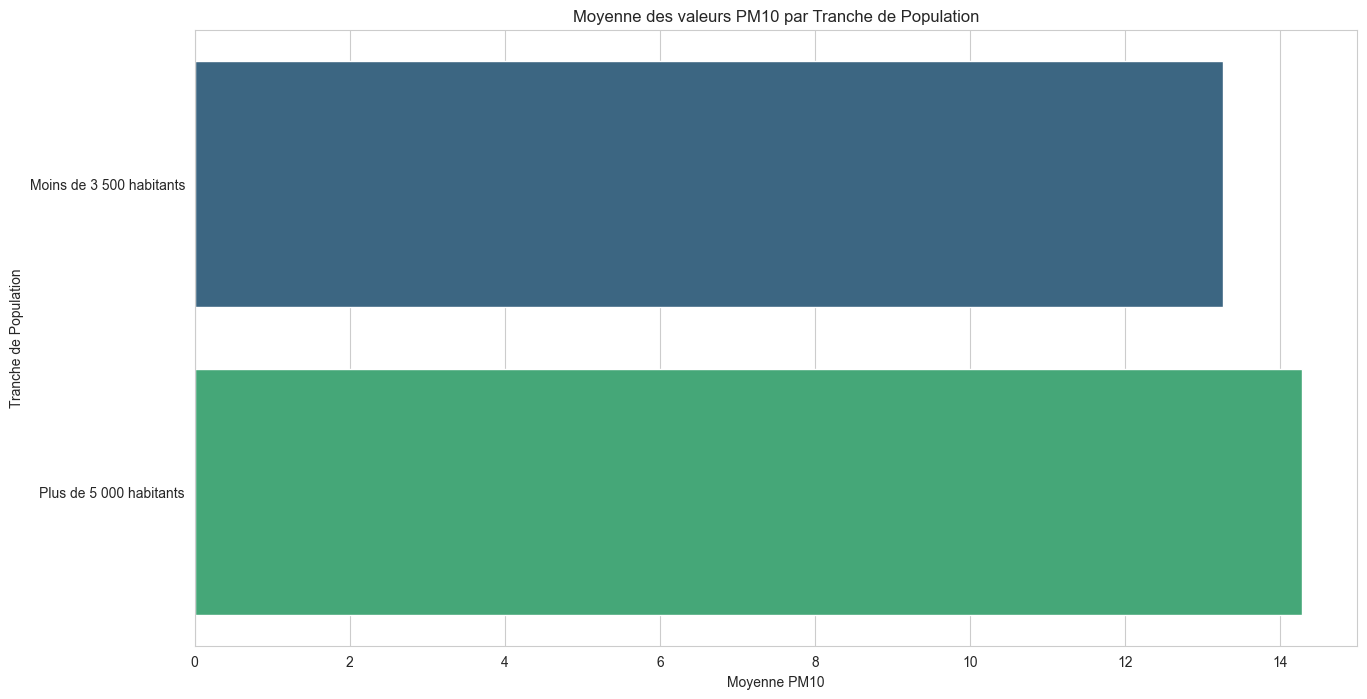

In [206]:
import matplotlib.pyplot as plt
import seaborn as sns

# Vérifier si la colonne 'tranche_population' existe
if 'tranche_population' in dfPM10.columns:
    # Calculer la moyenne de PM10 pour chaque tranche de population
    population_means = dfPM10.groupby('tranche_population')['valeur'].mean().reset_index()

    # Trier les tranches de population pour un affichage ordonné
    population_means = population_means.sort_values('tranche_population')

    # Créer un graphique en barres
    plt.figure(figsize=(15, 8))
    sns.barplot(data=population_means, x='valeur', y='tranche_population', palette='viridis', hue='tranche_population', dodge=False, legend=False)

    plt.xlabel('Moyenne PM10')
    plt.ylabel('Tranche de Population')
    plt.title('Moyenne des valeurs PM10 par Tranche de Population')
    plt.show()
else:
    print("La colonne 'tranche_population' n'existe pas dans le DataFrame.")


## Ajout d'alerte quand les variables de seuils sont dépassées
### Pour les valeurs de l'objectif de la qualité mensuel


In [244]:
import calendar
import pandas as pd

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Grouper les données par année, mois, département et commune
dfPM10['année'] = dfPM10['date_heure_tu'].dt.year
dfPM10['mois'] = dfPM10['date_heure_tu'].dt.month
grouped = dfPM10.groupby(['année', 'mois', 'departement_nom', 'nom_commune'])[['valeur']].mean().reset_index()

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped['valeur'] = grouped['valeur'].round(1)

# Créer la colonne indiquant si la moyenne mensuelle dépasse le seuil
grouped['depasse_objectif_qualite'] = grouped['valeur'] > OBJECTIF_QUALITE_PM10_MENSUEL

# Extraire les mois en lettres
grouped['mois_lettres'] = grouped['mois'].apply(lambda x: calendar.month_name[x])

# Regrouper les alertes par type
alertes_qualite = grouped[grouped['depasse_objectif_qualite']]

# Afficher les alertes par type pour les moyennes mensuelles avec le département et la commune
if not alertes_qualite.empty:
    print("Alertes pour l'Objectif de Qualité mensuel:")
    for index, row in alertes_qualite.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse l'Objectif de Qualité mensuel ({OBJECTIF_QUALITE_PM10_MENSUEL} µg/m3) en {row['mois_lettres']} {row['année']} dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour l'Objectif de Qualité mensuel.")


Alertes pour l'Objectif de Qualité mensuel:
Alerte: Valeur moyenne 21.1 µg/m3 dépasse l'Objectif de Qualité mensuel (16 µg/m3) en janvier 2024 dans la commune Bouguenais du département Loire-Atlantique
Alerte: Valeur moyenne 17.5 µg/m3 dépasse l'Objectif de Qualité mensuel (16 µg/m3) en janvier 2024 dans la commune Frossay du département Loire-Atlantique
Alerte: Valeur moyenne 18.2 µg/m3 dépasse l'Objectif de Qualité mensuel (16 µg/m3) en janvier 2024 dans la commune Montoir-De-Bretagne du département Loire-Atlantique
Alerte: Valeur moyenne 18.8 µg/m3 dépasse l'Objectif de Qualité mensuel (16 µg/m3) en janvier 2024 dans la commune Nantes du département Loire-Atlantique
Alerte: Valeur moyenne 22.6 µg/m3 dépasse l'Objectif de Qualité mensuel (16 µg/m3) en janvier 2024 dans la commune Rezé du département Loire-Atlantique
Alerte: Valeur moyenne 16.8 µg/m3 dépasse l'Objectif de Qualité mensuel (16 µg/m3) en janvier 2024 dans la commune Saint-Etienne-De-Montluc du département Loire-Atlantiqu

### Pour les valeurs du seuil d’information et de recommandation 

In [245]:
import calendar
import pandas as pd

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Grouper les données par département, commune et par intervalle de 24 heures
dfPM10['date'] = dfPM10['date_heure_tu'].dt.date
grouped_24h = dfPM10.groupby(['date', 'departement_nom', 'nom_commune'])[['valeur']].mean().reset_index()

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped_24h['valeur'] = grouped_24h['valeur'].round(1)

# Créer la colonne indiquant si la moyenne sur 24 heures dépasse le seuil
grouped_24h['depasse_seuil_info_reco'] = grouped_24h['valeur'] > SEUIL_INFO_RECO

# Extraire l'année et le mois pour l'affichage
grouped_24h['année'] = pd.to_datetime(grouped_24h['date']).dt.year
grouped_24h['mois'] = pd.to_datetime(grouped_24h['date']).dt.month
grouped_24h['mois_lettres'] = grouped_24h['mois'].apply(lambda x: calendar.month_name[x])

# Regrouper les alertes par type
alertes_seuil = grouped_24h[grouped_24h['depasse_seuil_info_reco']]

# Afficher les alertes par type pour les moyennes sur 24 heures avec le département et la commune
if not alertes_seuil.empty:
    print("Alertes pour le Seuil d'Information et de Recommandation sur 24 heures:")
    for index, row in alertes_seuil.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse le Seuil d'Information et de Recommandation ({SEUIL_INFO_RECO} µg/m3) le {row['date']} dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour le Seuil d'Information et de Recommandation sur 24 heures.")


Alertes pour le Seuil d'Information et de Recommandation sur 24 heures:
Alerte: Valeur moyenne 26.2 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-03 dans la commune Rezé du département Loire-Atlantique
Alerte: Valeur moyenne 26.4 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-03 dans la commune Saint-Nazaire du département Loire-Atlantique
Alerte: Valeur moyenne 27.2 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-03 dans la commune Cholet du département Maine-et-Loire
Alerte: Valeur moyenne 25.8 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-09 dans la commune Saint-Denis-D'Anjou du département Mayenne
Alerte: Valeur moyenne 34.4 µg/m3 dépasse le Seuil d'Information et de Recommandation (25 µg/m3) le 2024-01-10 dans la commune Bouguenais du département Loire-Atlantique
Alerte: Valeur moyenne 27.9 µg/m3 dépasse le Seuil d'Information et de Recommandation (

### Pour les valeurs du seuils d'alerte

In [246]:
import calendar
import pandas as pd

# Convertir les colonnes de date en format datetime si ce n'est pas déjà fait
dfPM10['date_heure_tu'] = pd.to_datetime(dfPM10['date_heure_tu'])

# Grouper les données par département, commune et par intervalle de 24 heures
dfPM10['date'] = dfPM10['date_heure_tu'].dt.date
grouped_24h = dfPM10.groupby(['date', 'departement_nom', 'nom_commune'])[['valeur']].mean().reset_index()

# Arrondir les valeurs moyennes à un chiffre après la virgule
grouped_24h['valeur'] = grouped_24h['valeur'].round(1)

# Créer la colonne indiquant si la moyenne sur 24 heures dépasse le seuil
grouped_24h['depasse_seuil_alerte'] = grouped_24h['valeur'] > SEUIL_ALERTE

# Extraire l'année et le mois pour l'affichage
grouped_24h['année'] = pd.to_datetime(grouped_24h['date']).dt.year
grouped_24h['mois'] = pd.to_datetime(grouped_24h['date']).dt.month
grouped_24h['mois_lettres'] = grouped_24h['mois'].apply(lambda x: calendar.month_name[x])

# Regrouper les alertes par type
alertes_alerte = grouped_24h[grouped_24h['depasse_seuil_alerte']]

# Afficher les alertes par type pour les moyennes sur 24 heures avec le département et la commune
if not alertes_alerte.empty:
    print("Alertes pour le Seuil d'Alerte sur 24 heures:")
    for index, row in alertes_alerte.iterrows():
        print(f"Alerte: Valeur moyenne {row['valeur']} µg/m3 dépasse le Seuil d'Alerte ({SEUIL_ALERTE} µg/m3) le {row['date']} dans la commune {row['nom_commune']} du département {row['departement_nom']}")
else:
    print("Aucune alerte pour le Seuil d'Alerte sur 24 heures.")


Alertes pour le Seuil d'Alerte sur 24 heures:
Alerte: Valeur moyenne 43.8 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune Bouguenais du département Loire-Atlantique
Alerte: Valeur moyenne 41.1 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune Nantes du département Loire-Atlantique
Alerte: Valeur moyenne 43.8 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune Rezé du département Loire-Atlantique
Alerte: Valeur moyenne 42.1 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune Angers du département Maine-et-Loire
Alerte: Valeur moyenne 43.5 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-01-14 dans la commune La Roche-Sur-Yon du département Vendée
Alerte: Valeur moyenne 40.1 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-02-04 dans la commune Montoir-De-Bretagne du département Loire-Atlantique
Alerte: Valeur moyenne 40.1 µg/m3 dépasse le Seuil d'Alerte (40 µg/m3) le 2024-02-05 dans la commune 

# Ajout des entreprises